# Introduction
## Problem statement 
A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia.

The company wants to know:

1. Which variables are significant in predicting the price of a house, and
2. How well those variables describe the price of a house.

## Business goal
You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market. 

## Assignment
Please visit [my github](https://github.com/cuonghv0298/Advanced-Regression.git) for all information you need.

In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Understanding

In [2]:
def grab_col_names(dataframe, cat_th=15, car_th=20):
    
    """
    Returns the names of categorical, numerical, and categorical but cardinal variables in the dataset.
    Note: Numerical-looking categorical variables are also included in the categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe for which variable names are to be obtained.
        cat_th: int, optional
                Class threshold value for numerical but categorical variables.
        car_th: int, optional
                Class threshold value for categorical but cardinal variables.

    Returns
    ------
        cat_cols: list
                List of categorical variables.
        num_cols: list
                List of numerical variables.
        cat_but_car: list
                List of categorical but cardinal variables.
        num_but_cat: list 
                List of categorical but numerical variables.

    """

    # cat_cols, cat_but_car
    
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    return cat_cols, num_cols, cat_but_car

In [3]:
df = pd.read_csv('data/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

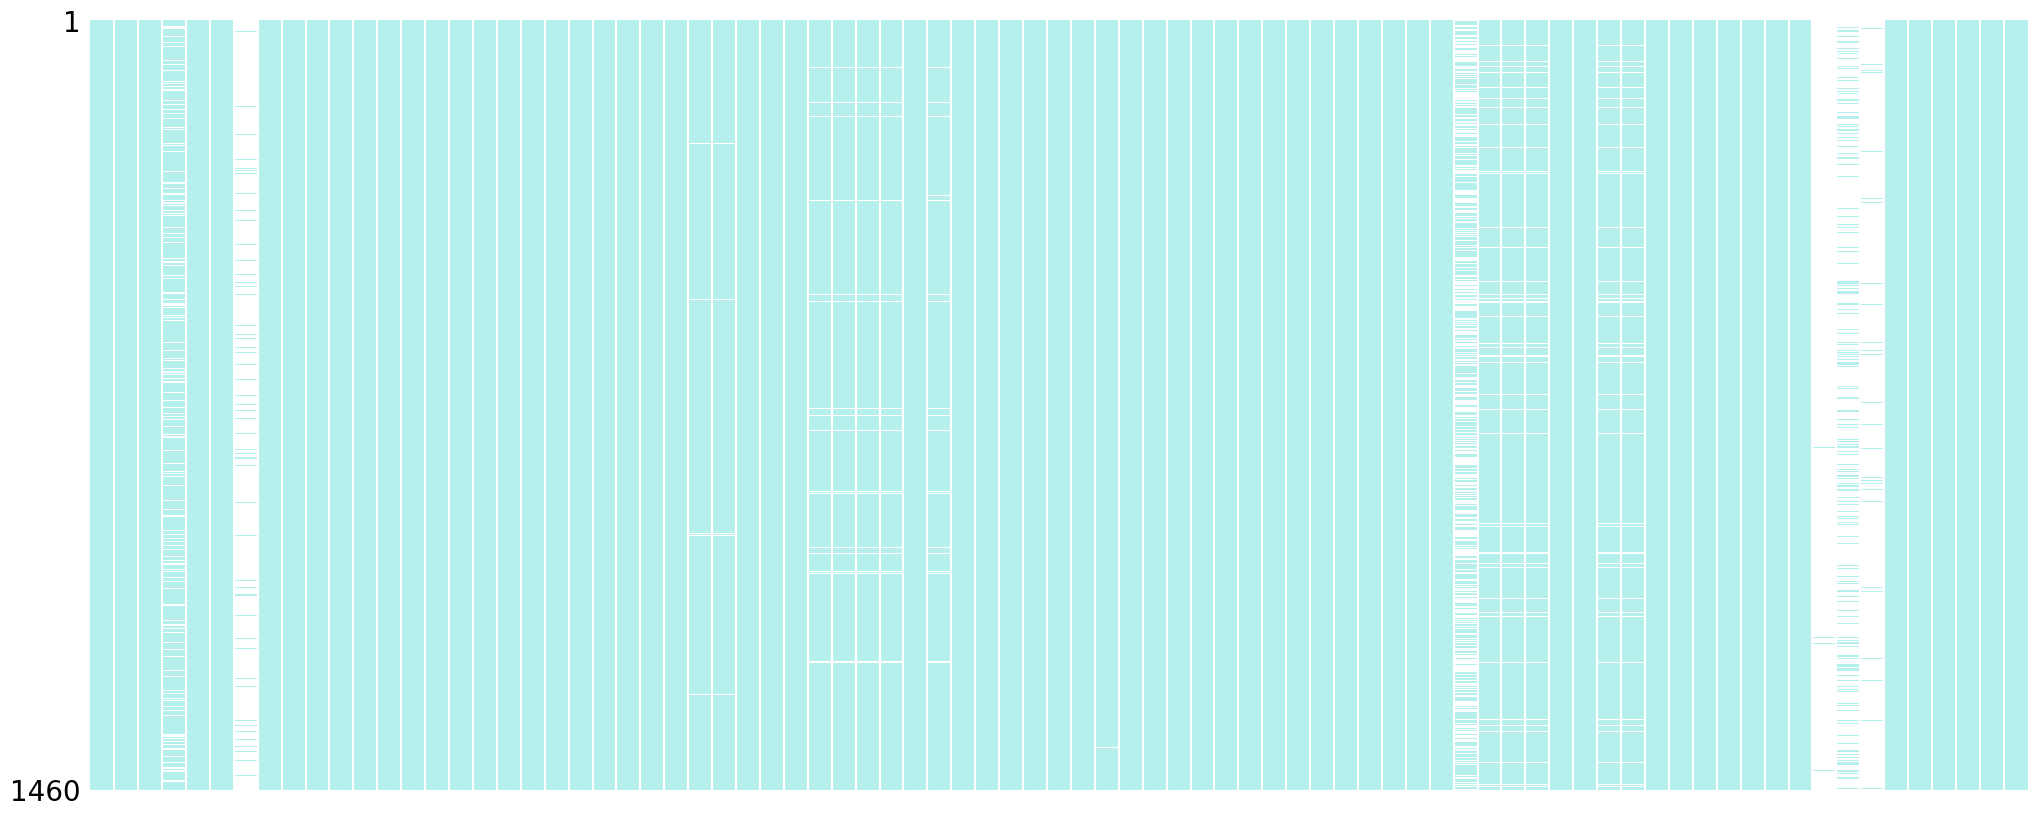

In [6]:
# Overview missing data
fig = msno.matrix(df, sparkline=False,color=( 181/255, 240/255, 237/255 ))
plt.show()

> We have to handle missing data problem

In [7]:
# Chekcing the percentage of Null values in all the columns
missing_values = round(df.isnull().sum()/len(df.index)*100,2).sort_values(ascending=False)[ round(df.isnull().sum()/len(df.index),2) > 0 ] 
print('Percentage of Missing Values in each column is as follows:')
print(missing_values)
print(f'{len(missing_values)} features have missing values')

Percentage of Missing Values in each column is as follows:
PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageYrBlt      5.55
GarageCond       5.55
GarageType       5.55
GarageFinish     5.55
GarageQual       5.55
BsmtFinType2     2.60
BsmtExposure     2.60
BsmtQual         2.53
BsmtCond         2.53
BsmtFinType1     2.53
MasVnrArea       0.55
MasVnrType       0.55
dtype: float64
18 features have missing values


> 5 features have more than 45% missing values.

In [8]:
# check duplicate
df_dup = df
df_dup.drop_duplicates(subset = None, inplace= True)
if df_dup.shape == df.shape:
    print('There have no duplicate')
else:
    print('Some duplicate in this dataset')

There have no duplicate


> 

Observations: 1460
Variables: 81
cat_cols: 56
num_cols: 24
cat_but_car: 1
num_but_cat: 14


array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'YearBuilt'}>],
       [<Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>],
       [<Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>],
       [<Axes: title={'center': 'GarageYrBlt'}>,
        <Axes: title={'center': 'GarageArea'}>,
        <Axes: title={'center': 'WoodDeckSF'}>,
        <Axes: title={'center': 'OpenPorchSF'}>,
        <Axes: title={'center': 'EnclosedPorch'}>],
       [<Axes: title={'center': '3SsnPorch'

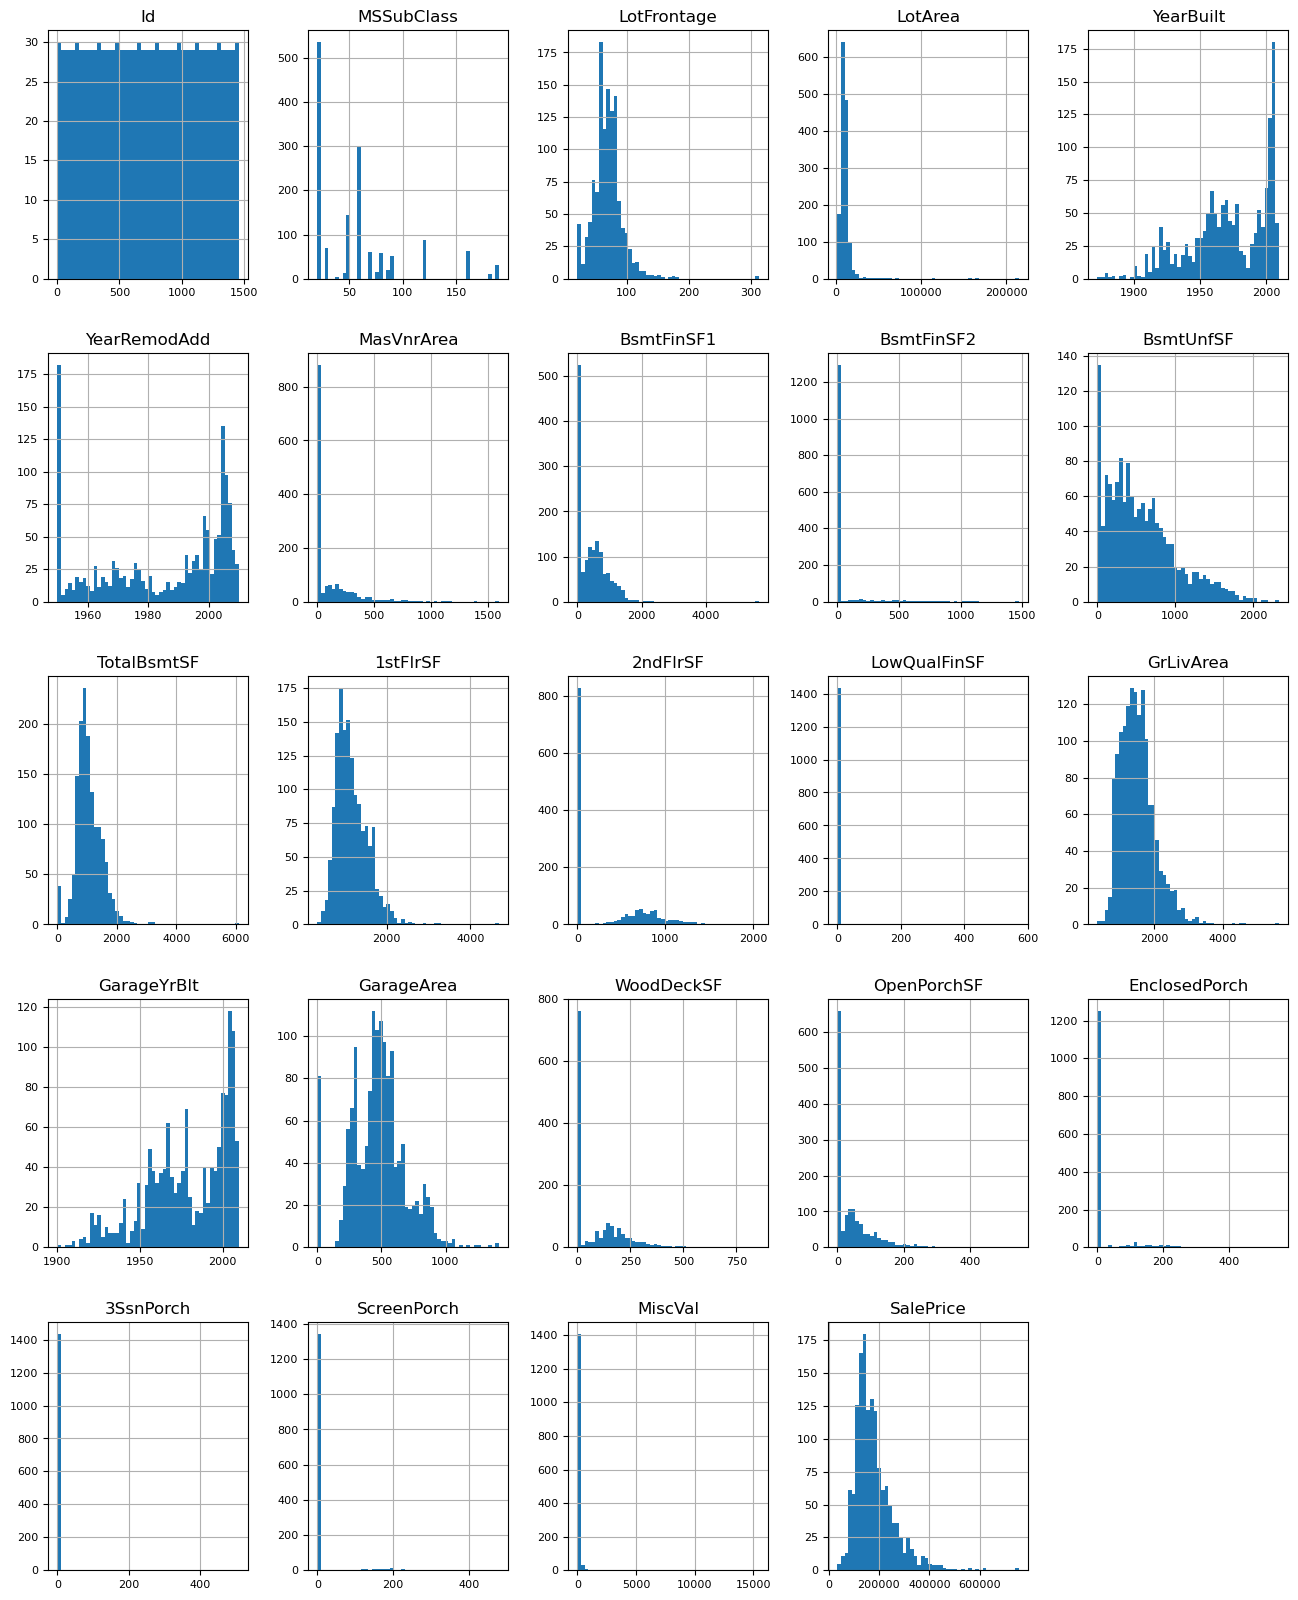

In [9]:
# pre-classify type of columns
cat_cols, num_cols, cat_but_car = grab_col_names(df)
df[num_cols].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)


> Many bias features

## EDA

In [10]:
def univariate_analysis1(df, column):
    _, p = plt.subplots(2,1, figsize=(16, 4))
    sns.distplot(df.loc[df[column].notnull(), column], kde=True, hist=True, ax=p[0])
    sns.boxplot(x=column, data=df, ax=p[1])
    p[0].set_xlabel(f'{column}')
    p[1].set_xlabel(f'{column}')
    plt.tight_layout()
    plt.show()
def drop_outliner(df, col):
    old_rows = len(df)
    q25 = df[col].quantile(0.25)
    q75 = df[col].quantile(0.75)
    iqr = q75 - q25
    upper = q75 + 1.5 * iqr
    new_df = df[df[col] < upper]
    new_rows = len(new_df)
    print('Percentage of dropped row: ', round((old_rows - new_rows)/old_rows*100,2), "%")
    return new_df

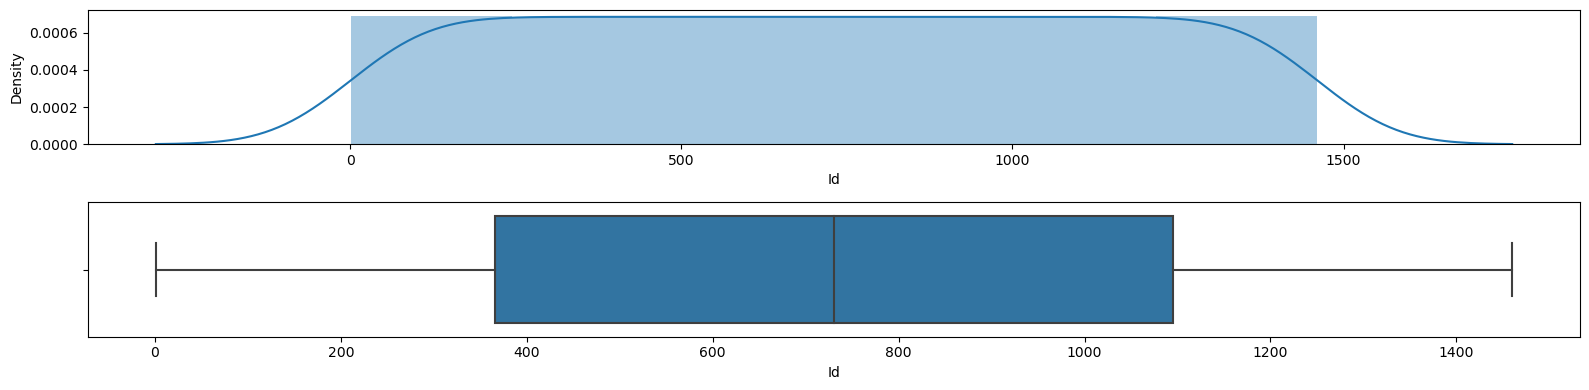

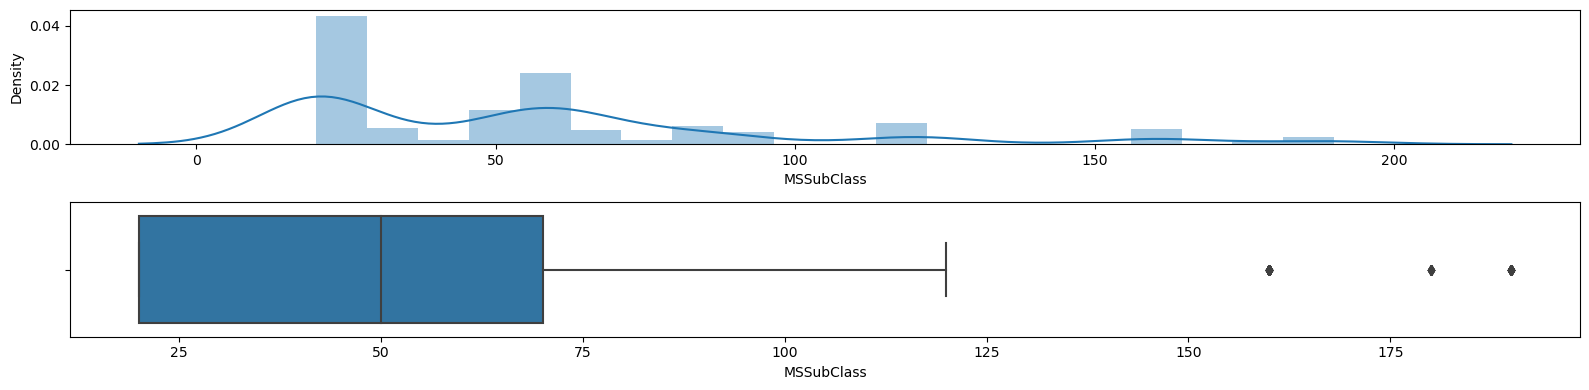

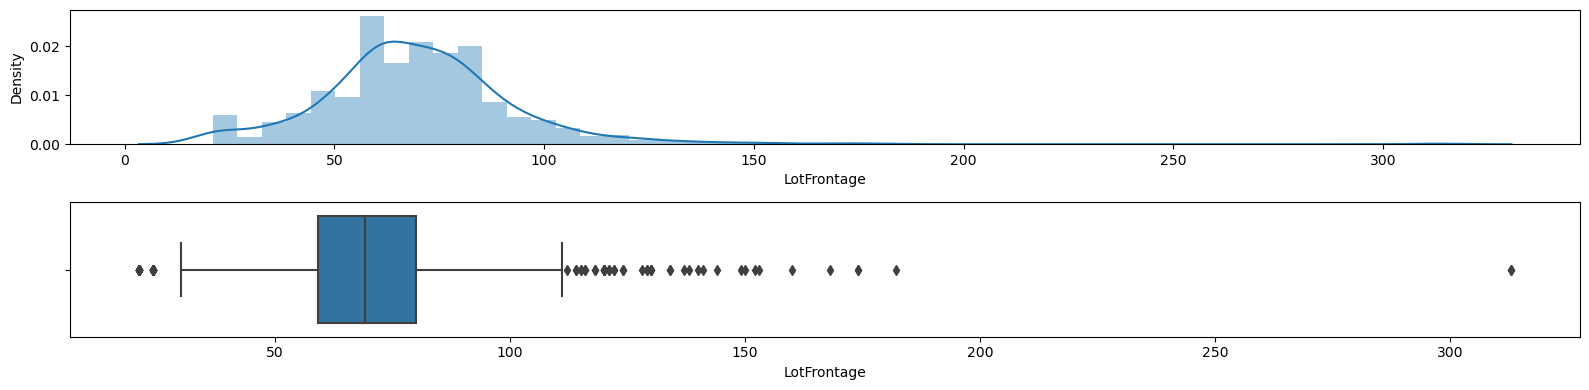

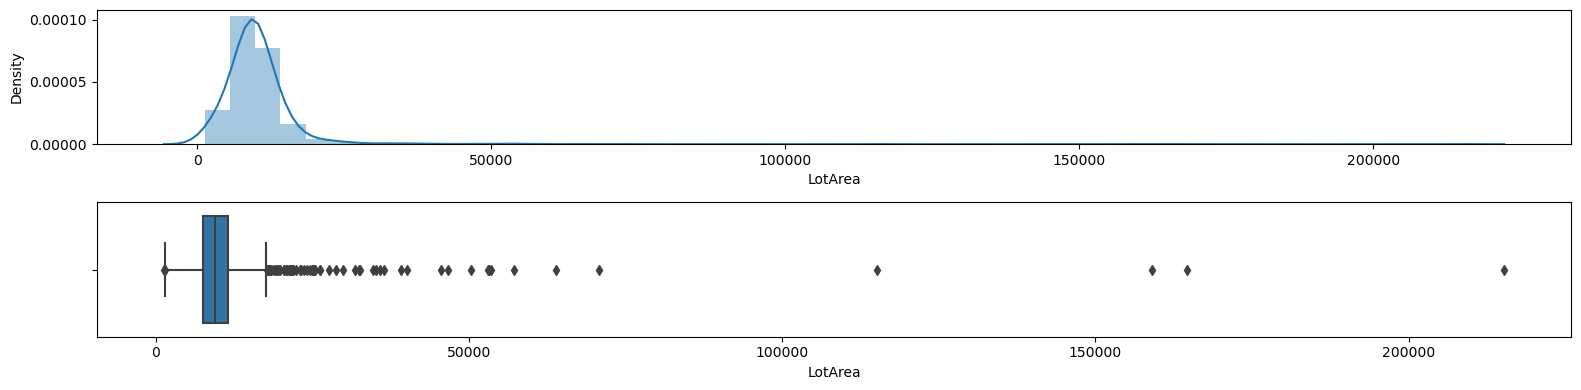

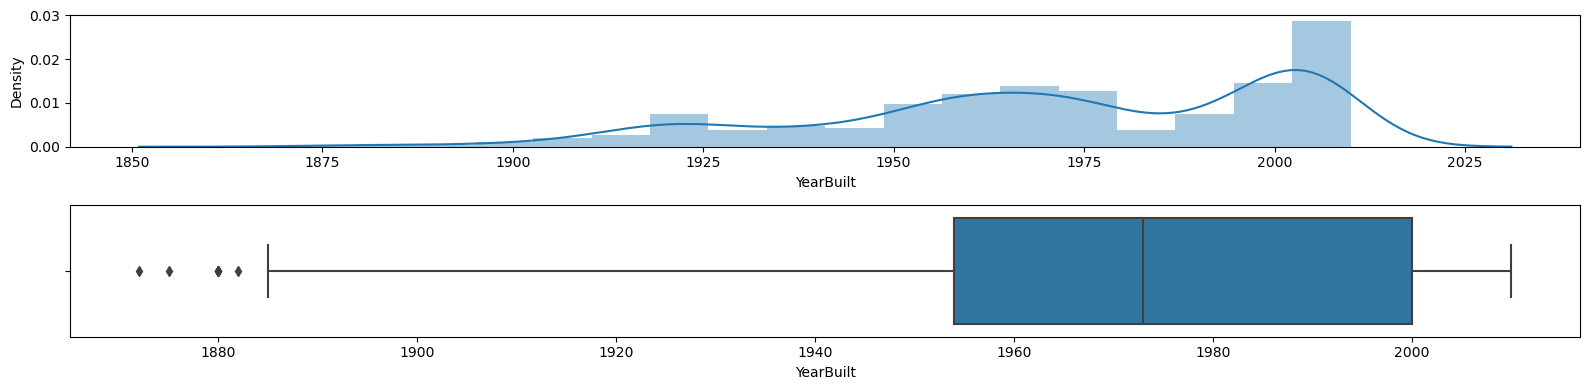

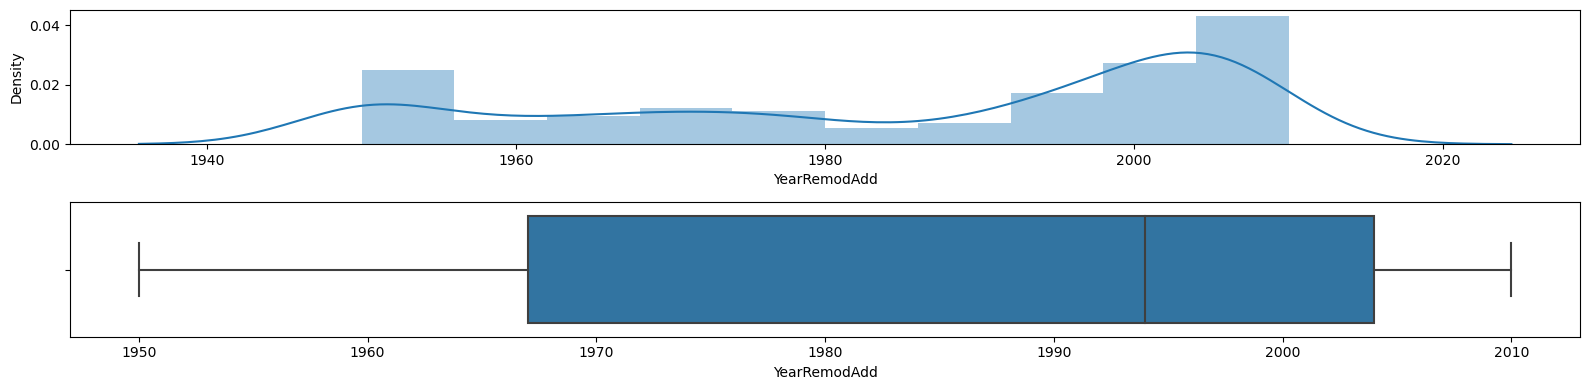

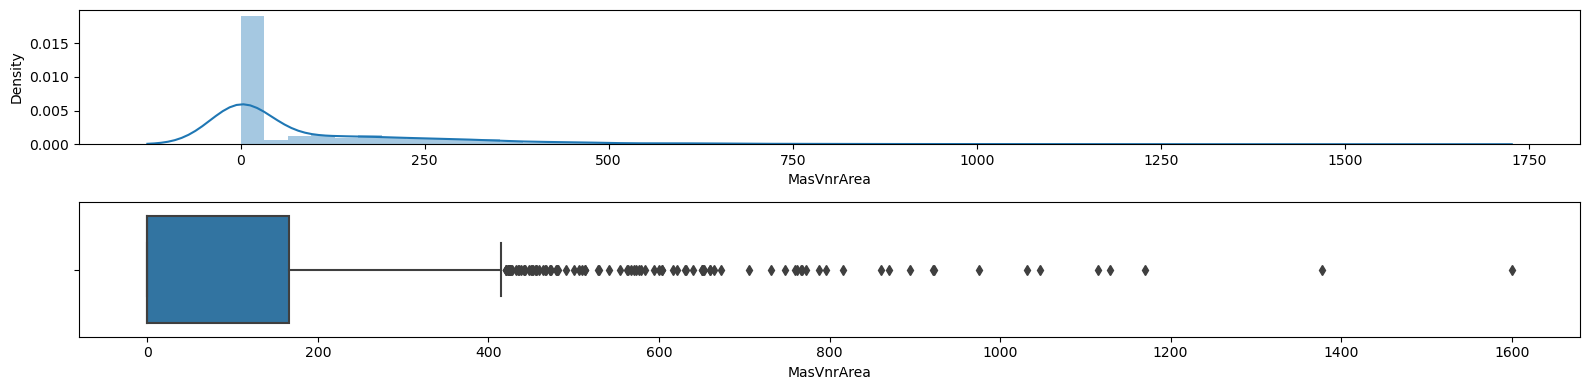

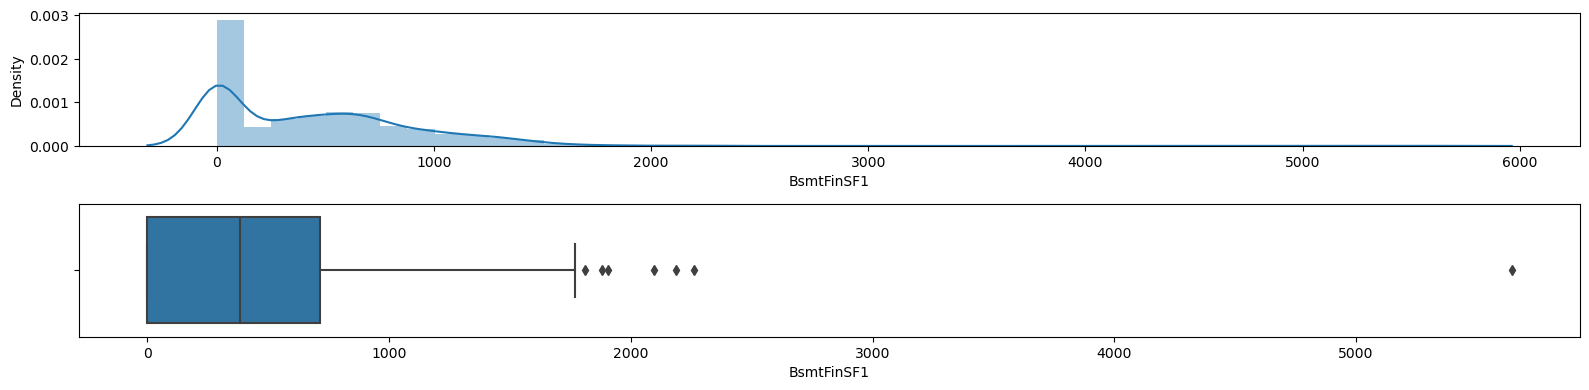

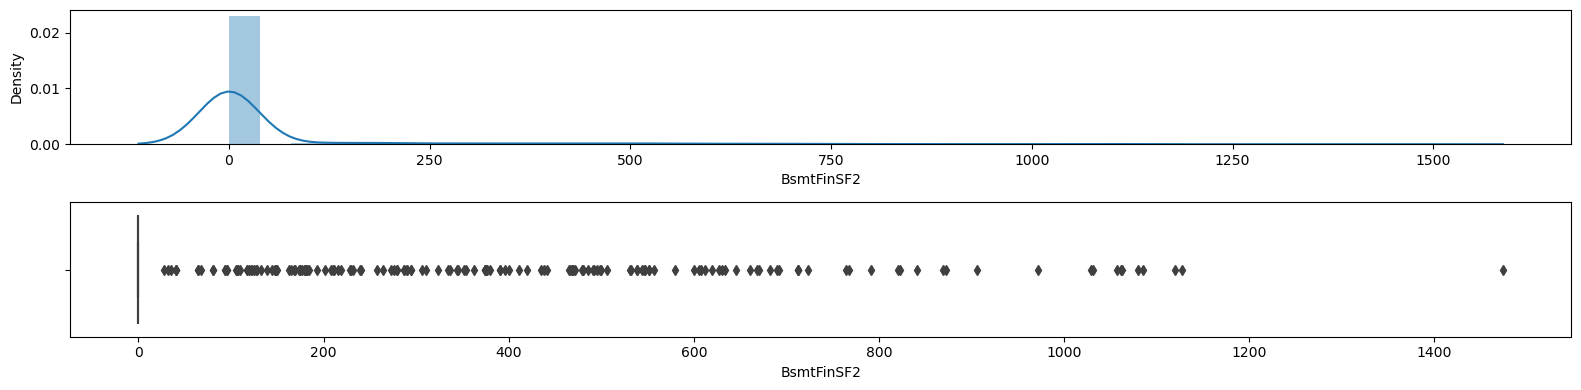

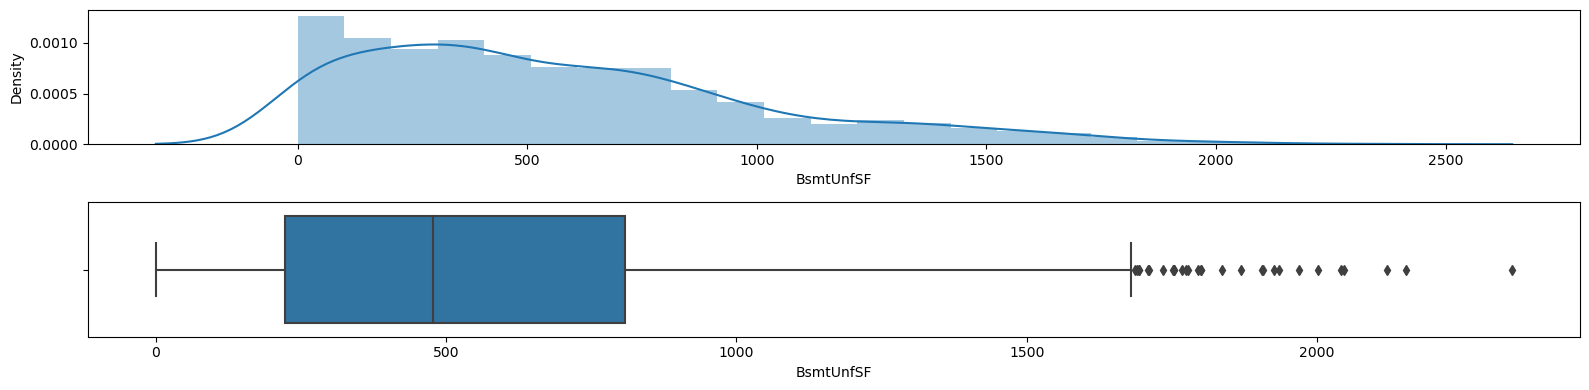

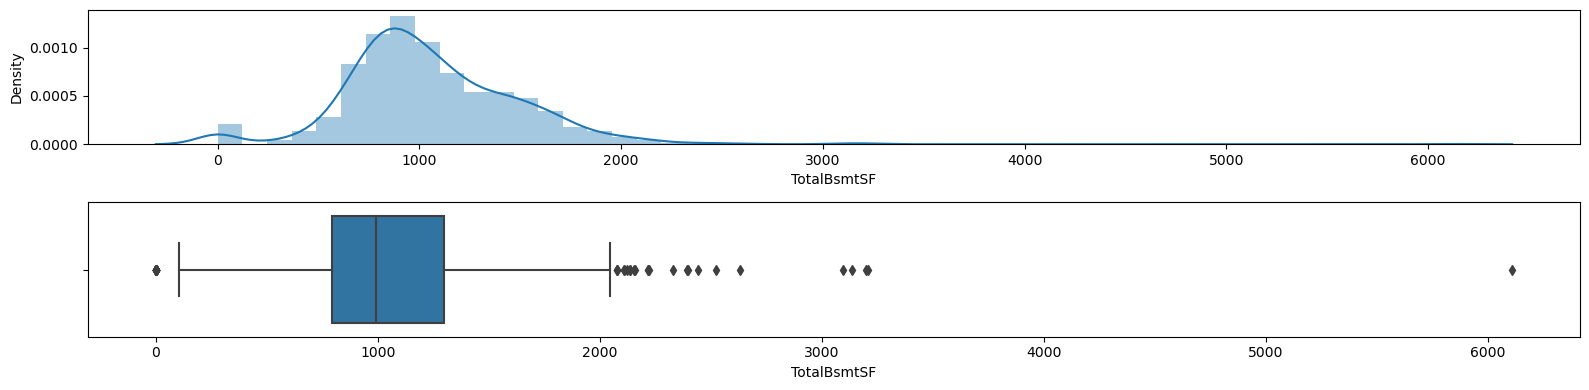

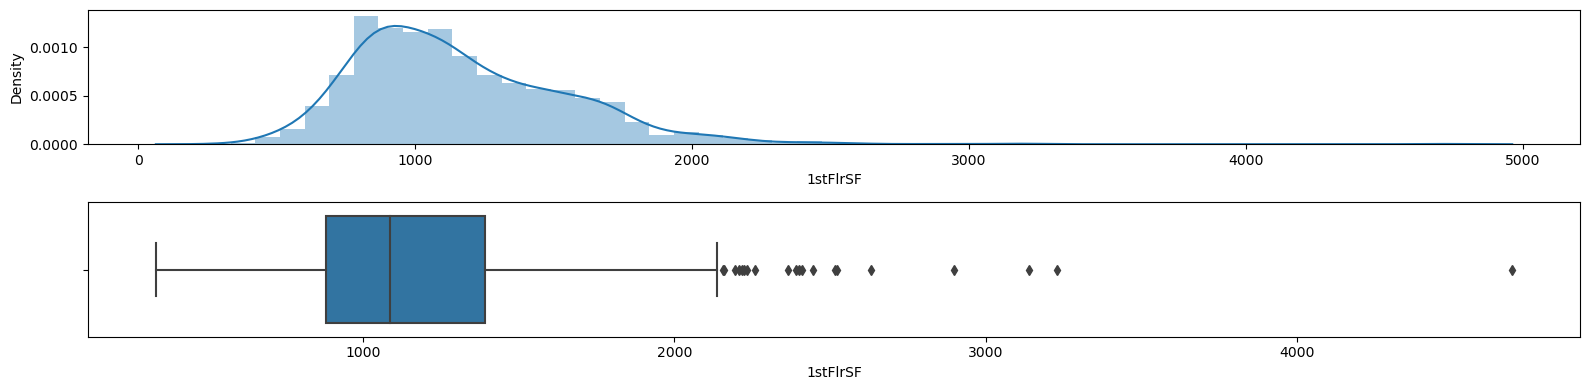

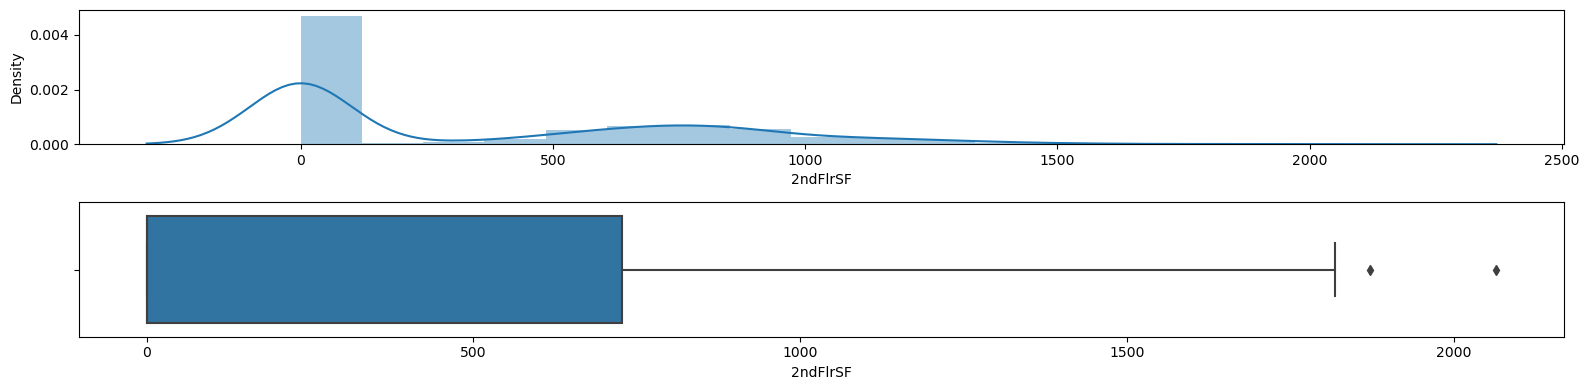

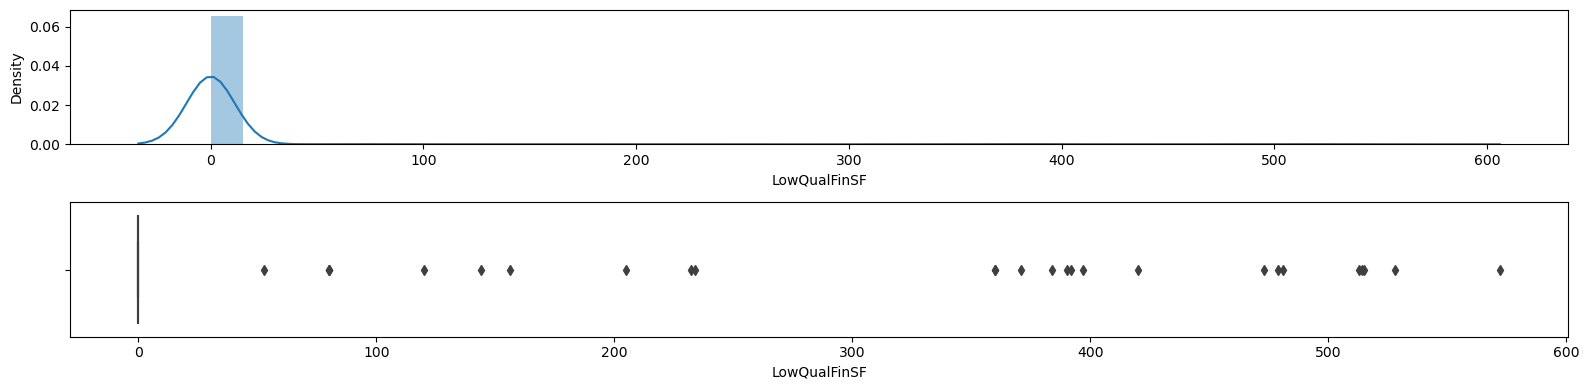

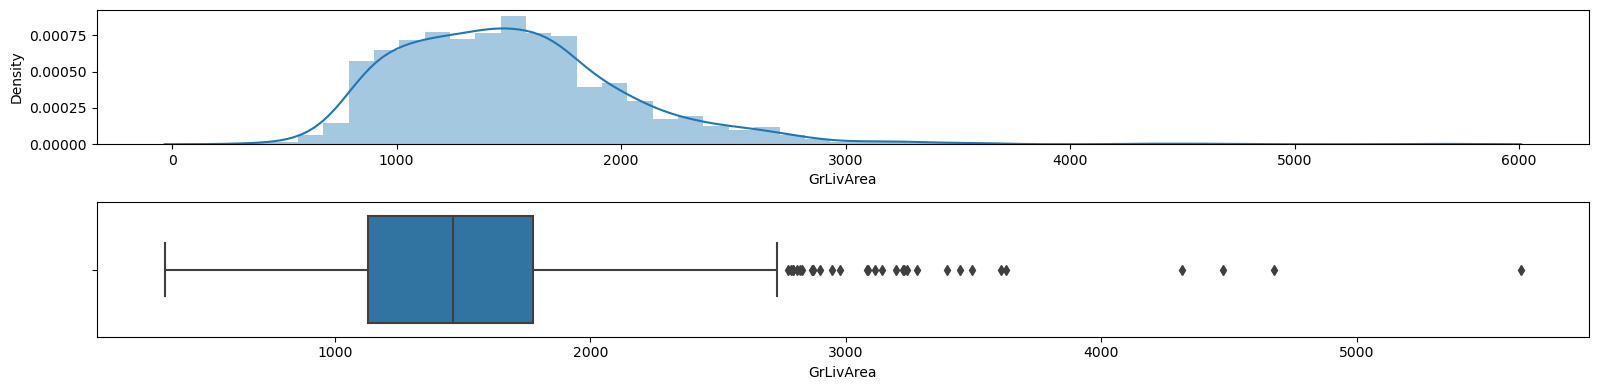

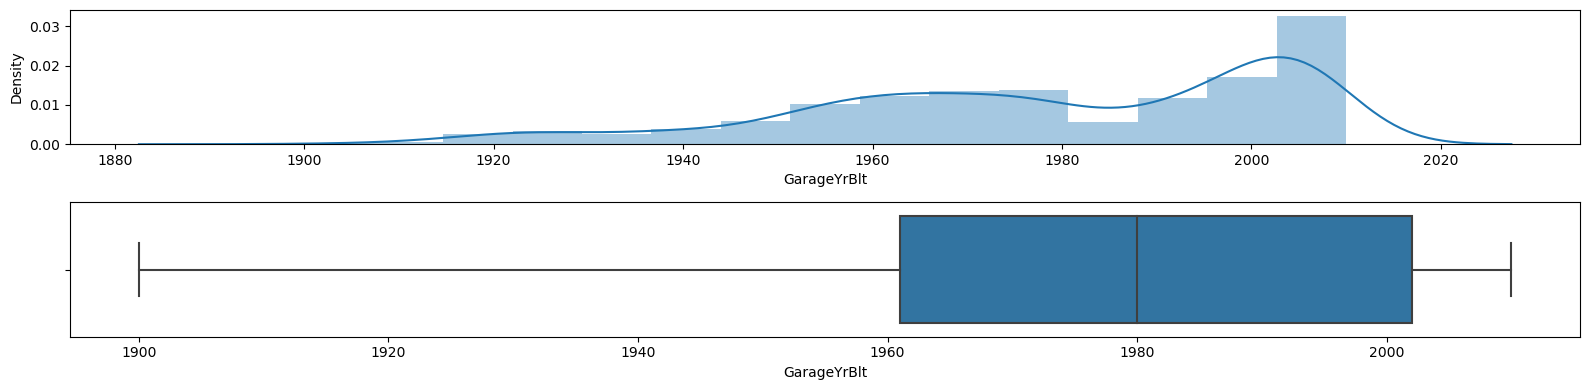

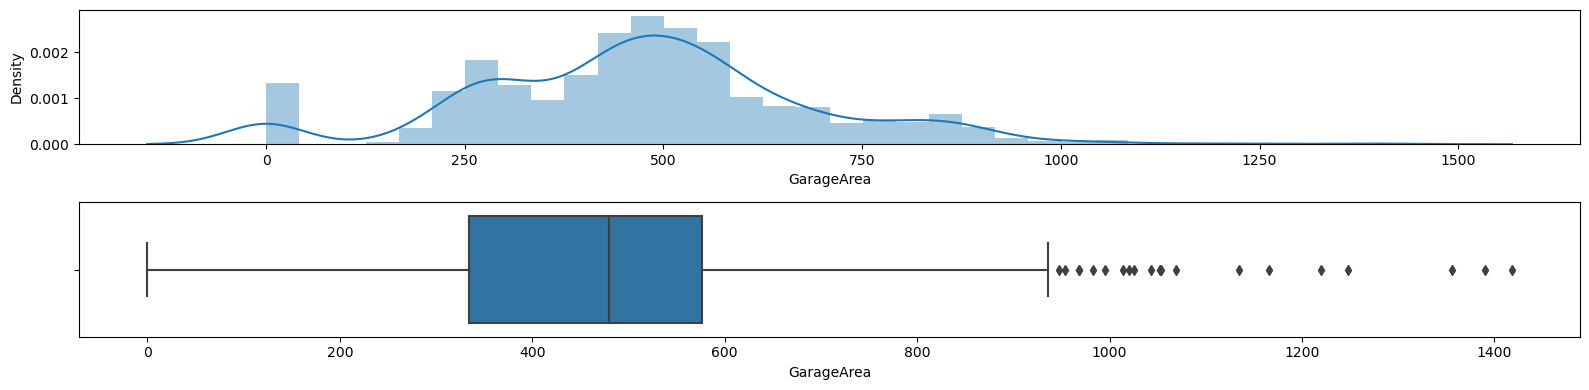

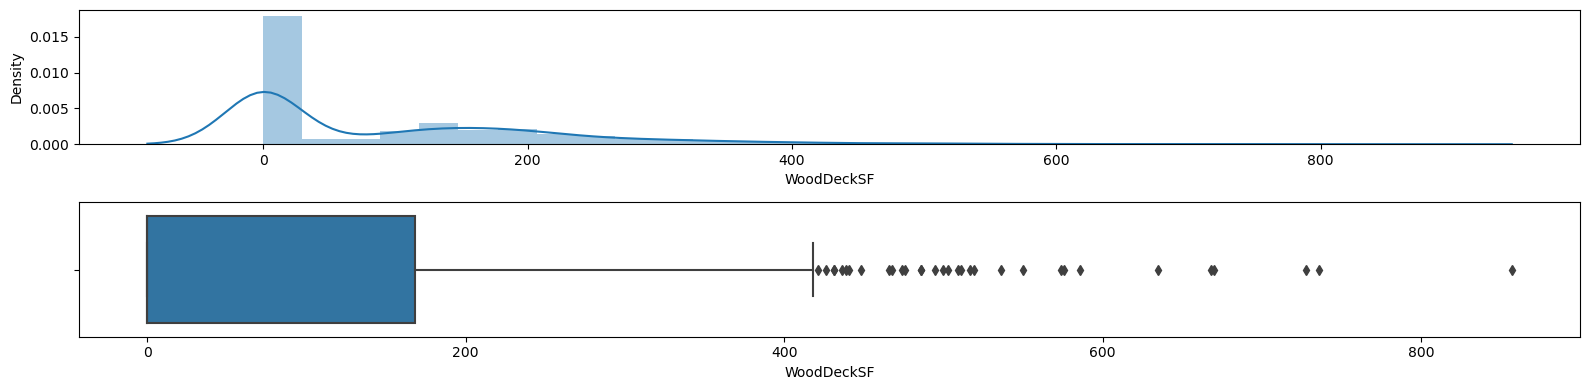

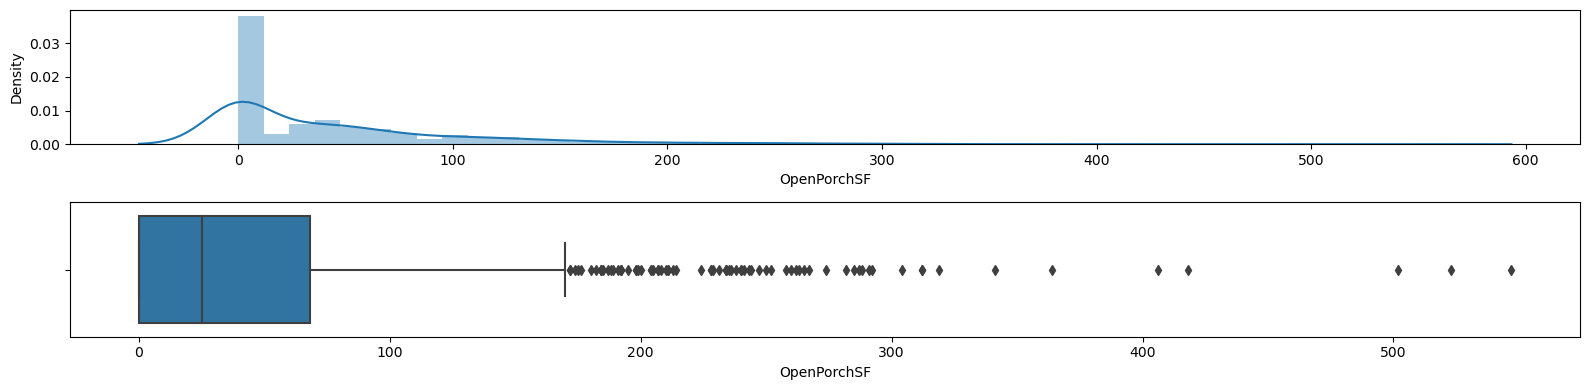

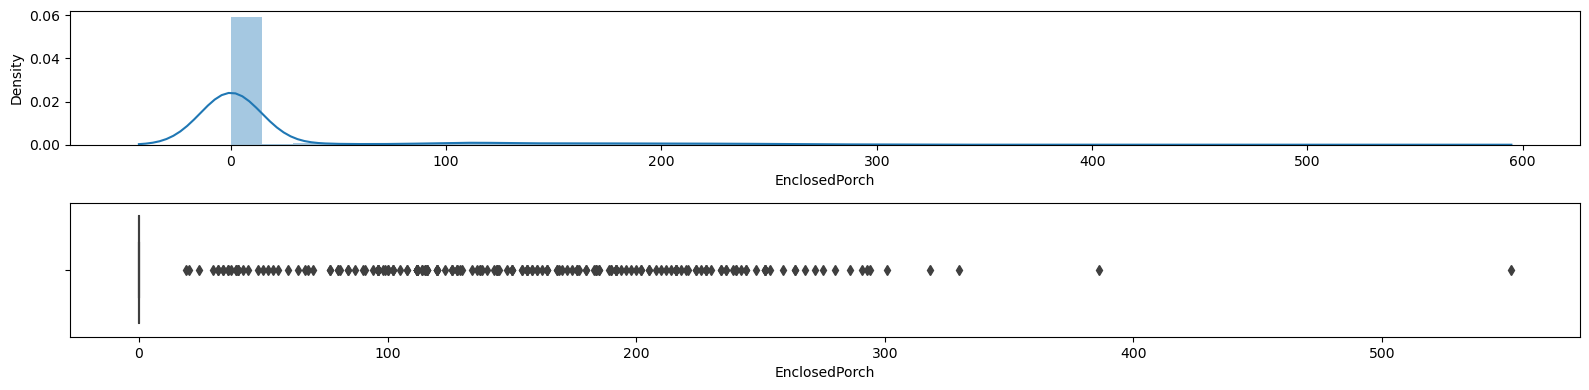

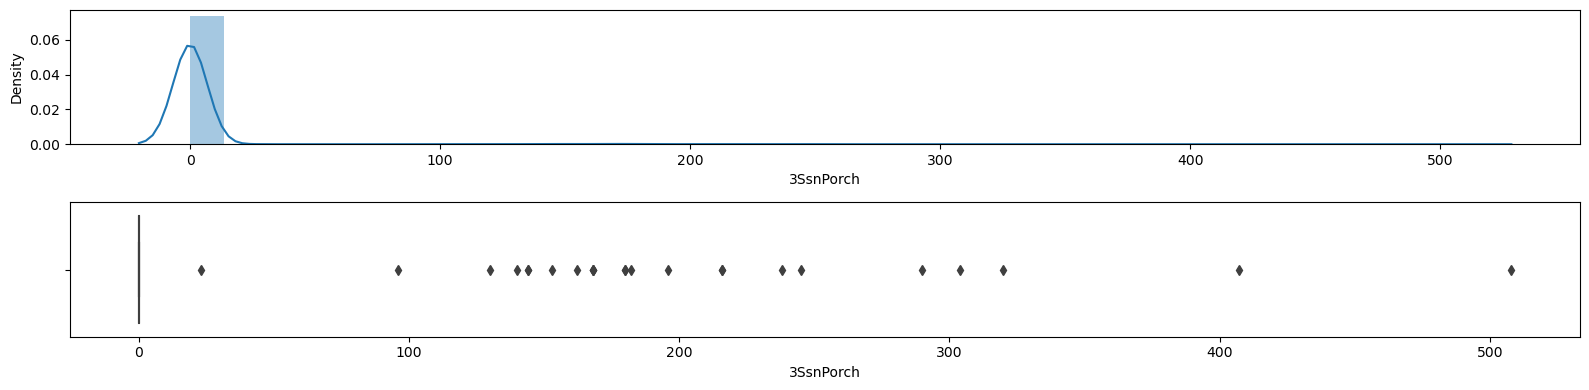

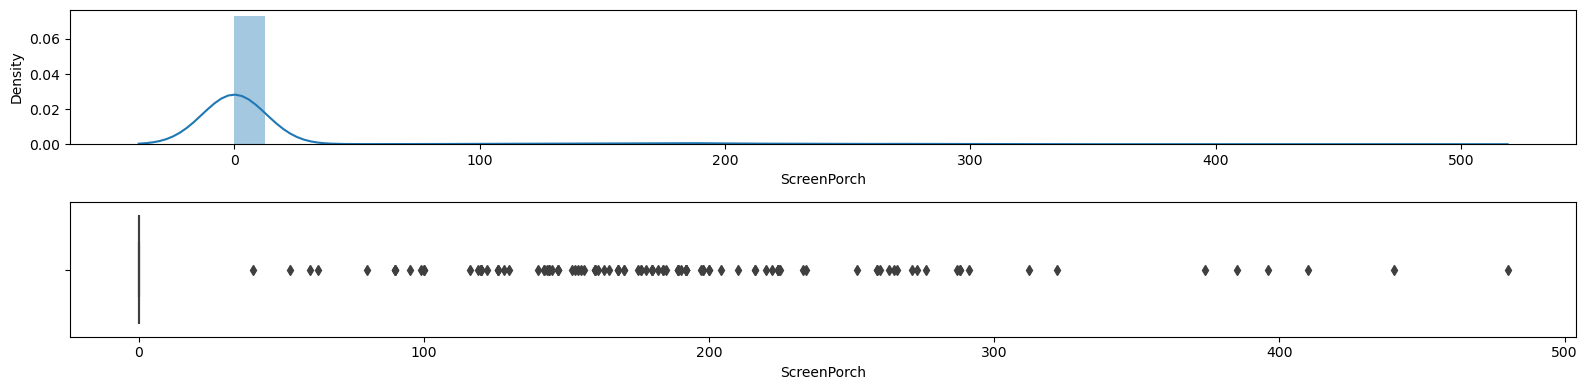

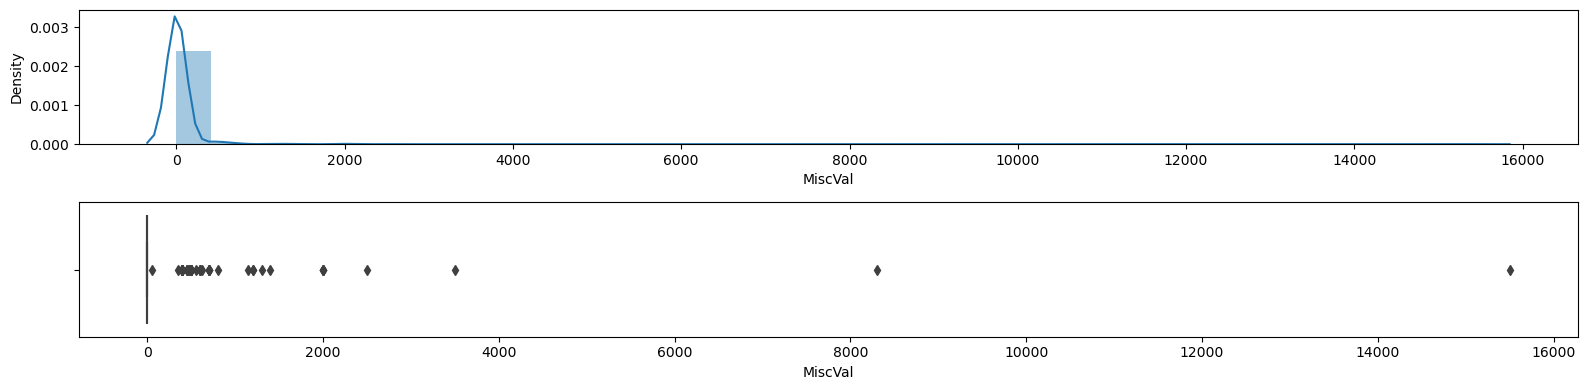

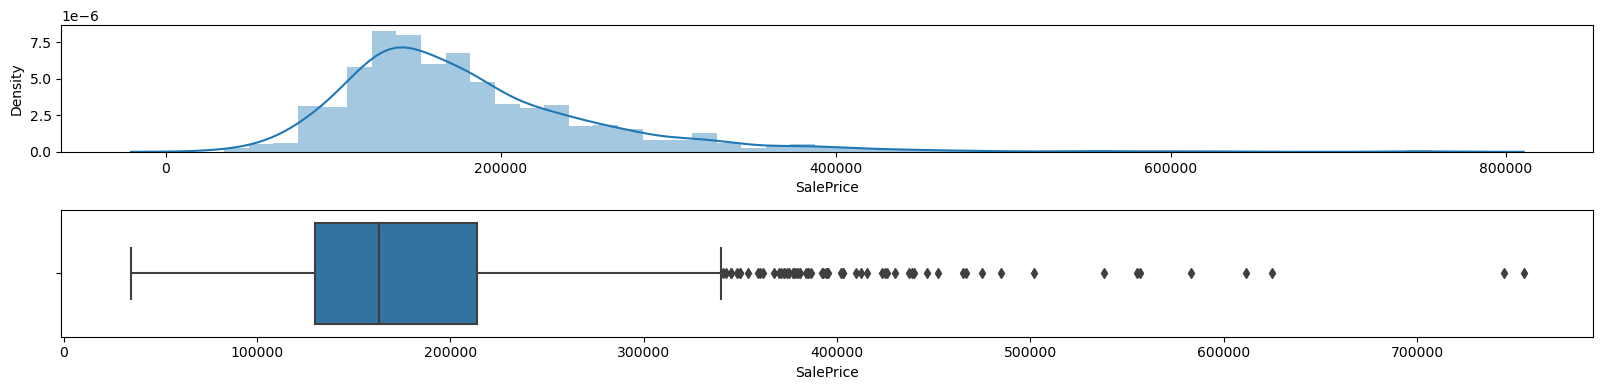

In [11]:
# plot dist and box
for c in num_cols:
    univariate_analysis1(df, c)

> Many outliers

In [12]:
# Drop noise features
noise_cols = ['Id','MiscVal', 'ScreenPorch', '3SsnPorch', 'EnclosedPorch','LowQualFinSF', 'BsmtFinSF2']
df = df.drop(columns= noise_cols)
# reset grab
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 1460
Variables: 74
cat_cols: 56
num_cols: 17
cat_but_car: 1
num_but_cat: 14


In [13]:
#drop outlier
for c in num_cols:
    print(f'drop outlier for: {c}')
    df= drop_outliner(df,c)

drop outlier for: MSSubClass
Percentage of dropped row:  7.05 %
drop outlier for: LotFrontage
Percentage of dropped row:  21.59 %
drop outlier for: LotArea
Percentage of dropped row:  3.57 %
drop outlier for: YearBuilt
Percentage of dropped row:  0.0 %
drop outlier for: YearRemodAdd
Percentage of dropped row:  0.0 %
drop outlier for: MasVnrArea
Percentage of dropped row:  6.73 %
drop outlier for: BsmtFinSF1
Percentage of dropped row:  0.1 %
drop outlier for: BsmtUnfSF
Percentage of dropped row:  1.46 %
drop outlier for: TotalBsmtSF
Percentage of dropped row:  1.17 %
drop outlier for: 1stFlrSF
Percentage of dropped row:  0.54 %
drop outlier for: 2ndFlrSF
Percentage of dropped row:  0.0 %
drop outlier for: GrLivArea
Percentage of dropped row:  2.16 %
drop outlier for: GarageYrBlt
Percentage of dropped row:  6.07 %
drop outlier for: GarageArea
Percentage of dropped row:  0.47 %
drop outlier for: WoodDeckSF
Percentage of dropped row:  1.42 %
drop outlier for: OpenPorchSF
Percentage of drop

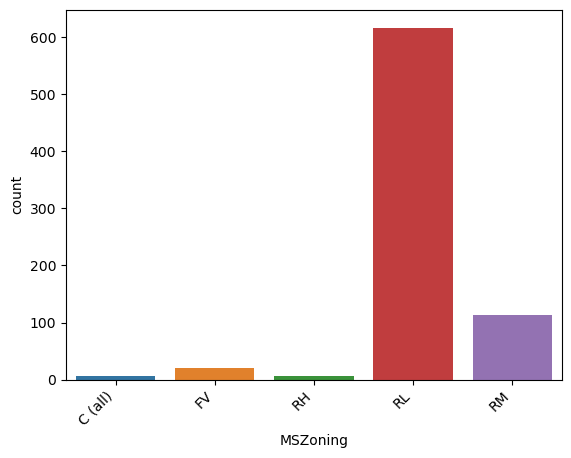

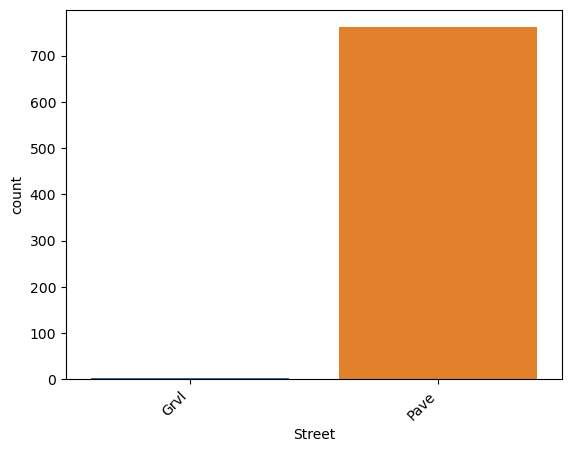

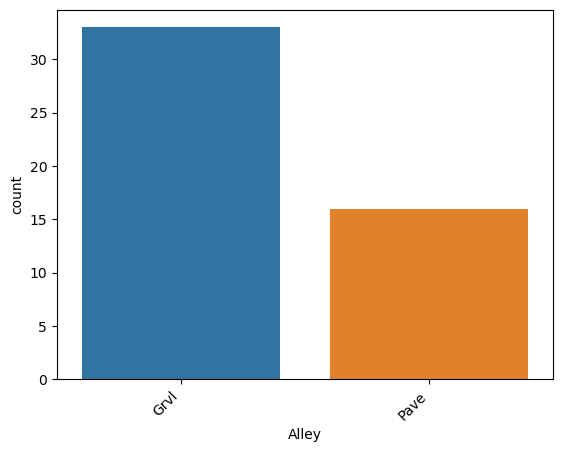

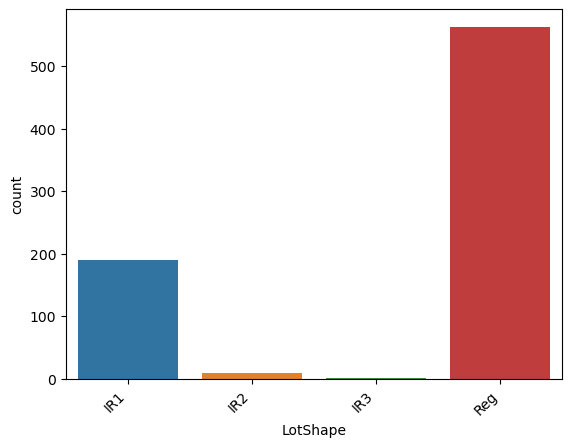

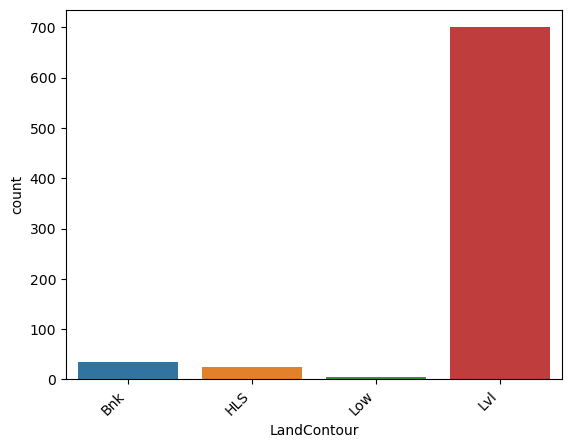

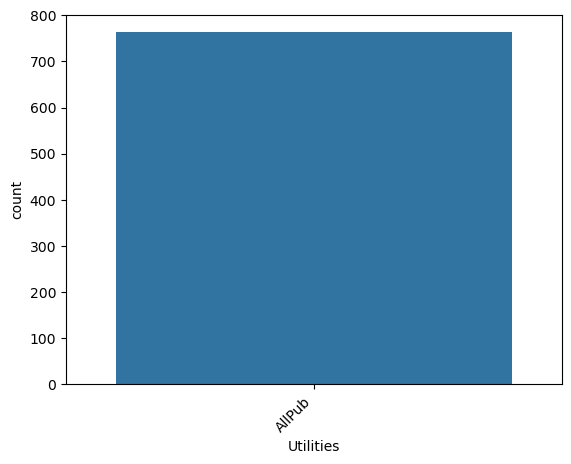

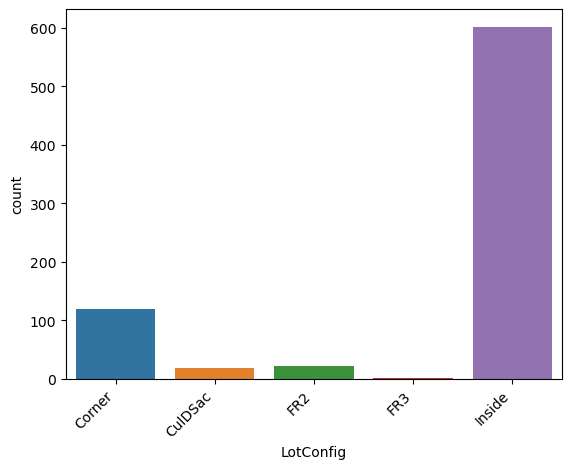

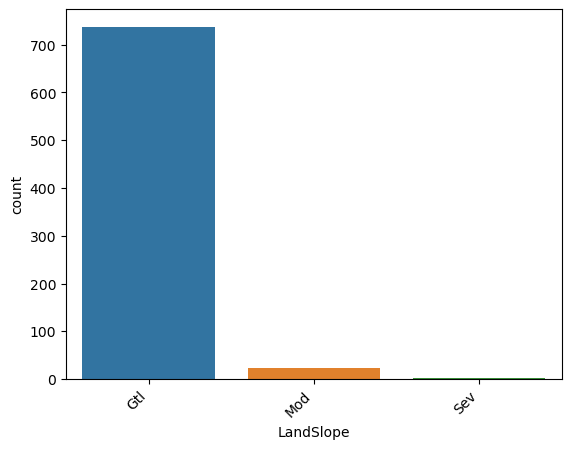

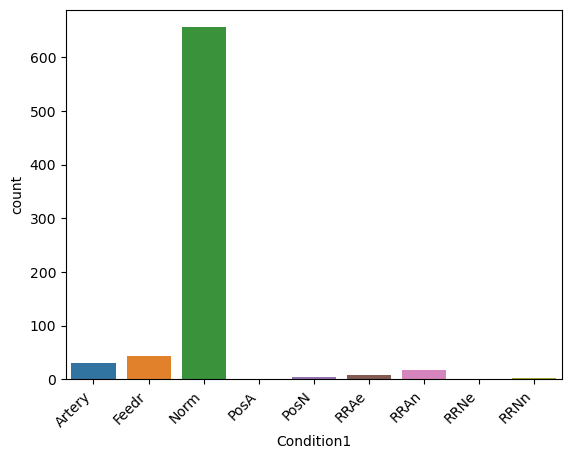

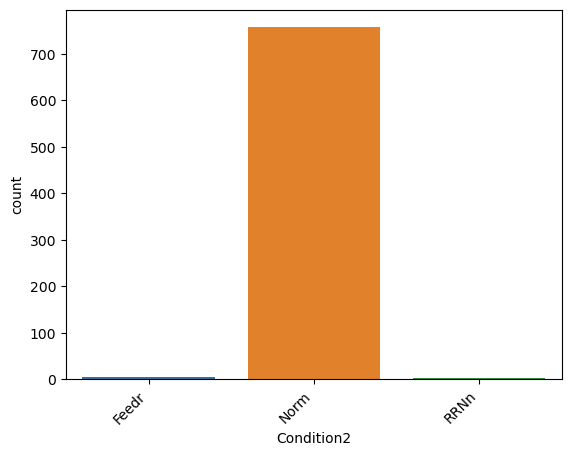

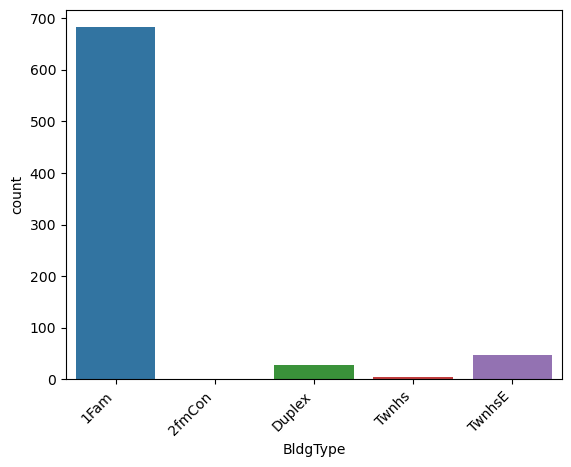

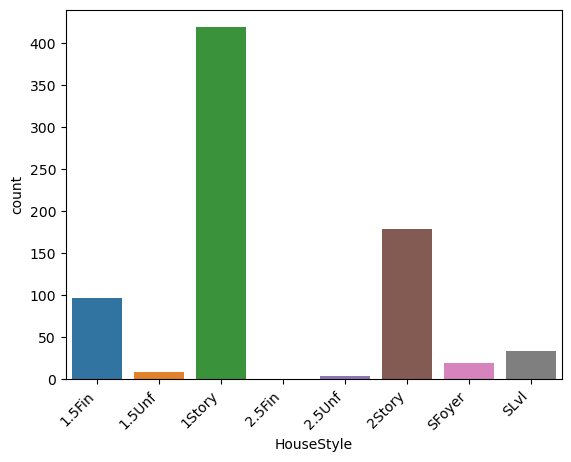

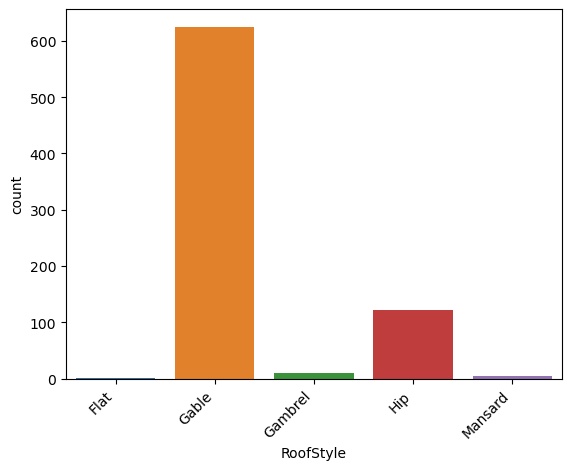

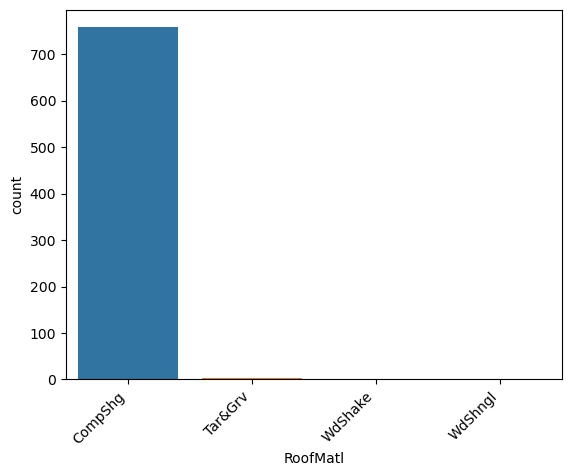

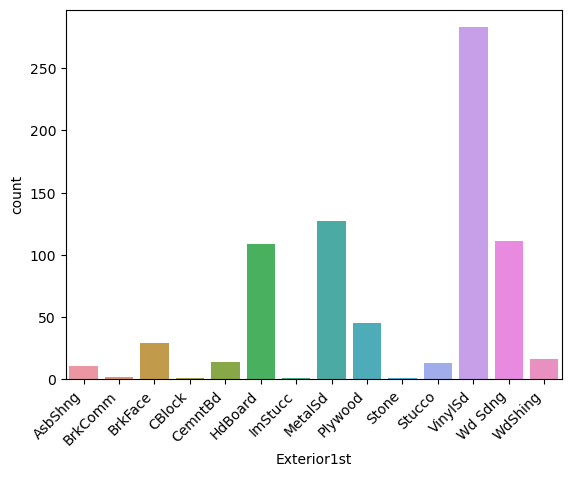

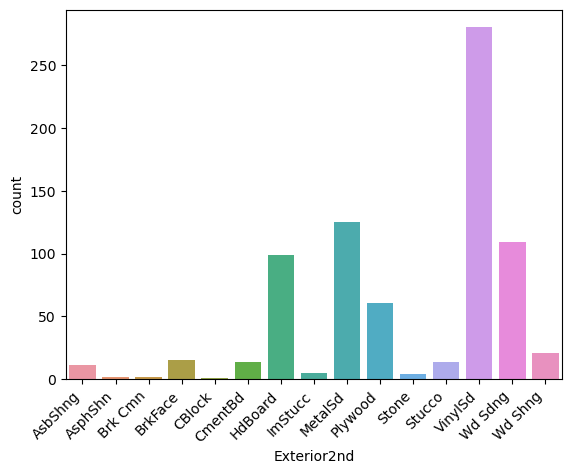

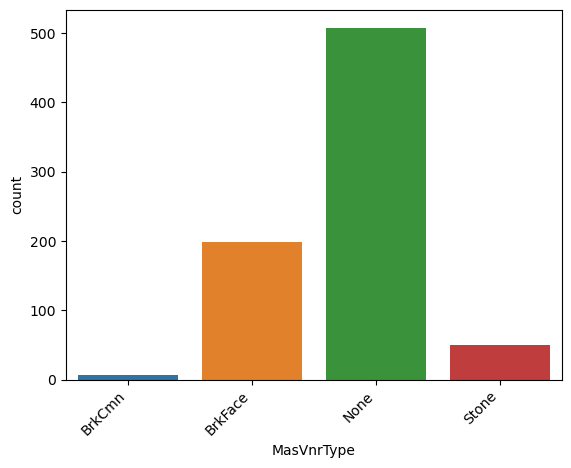

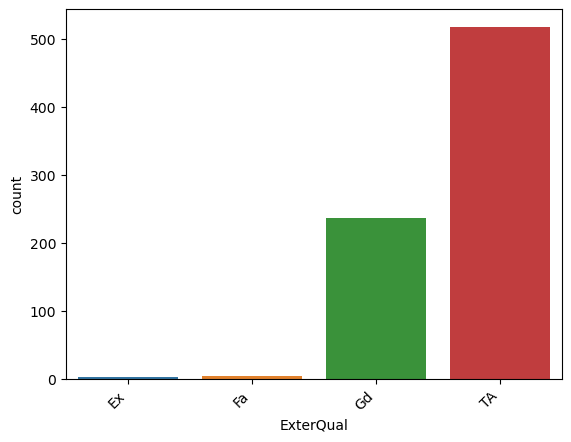

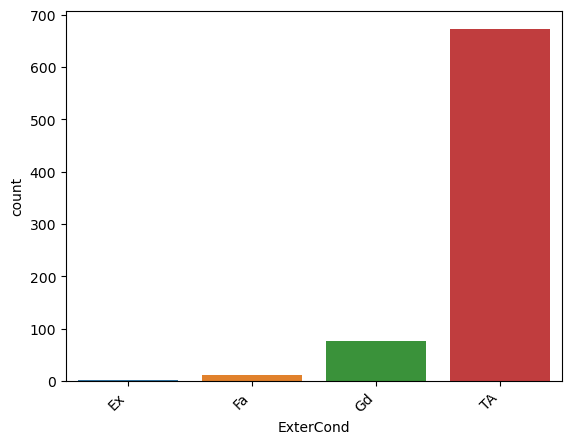

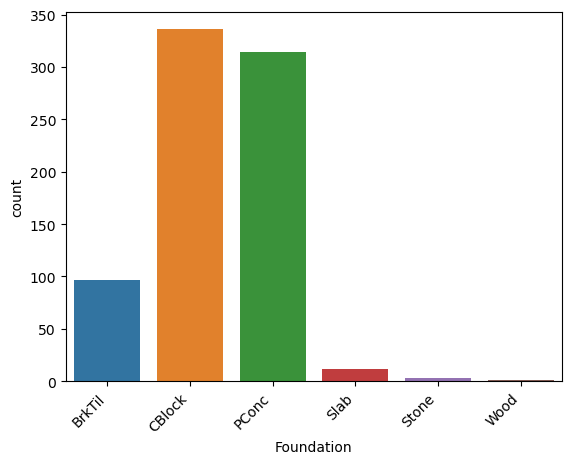

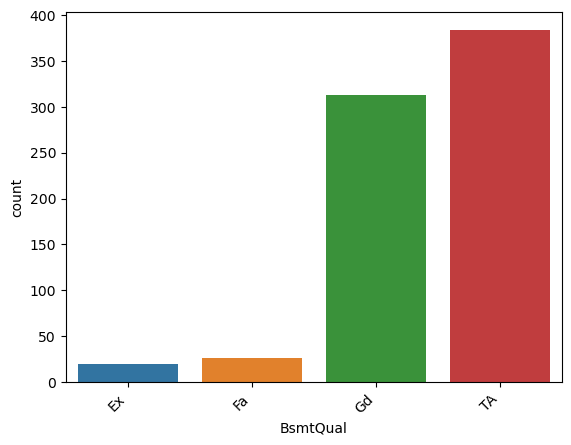

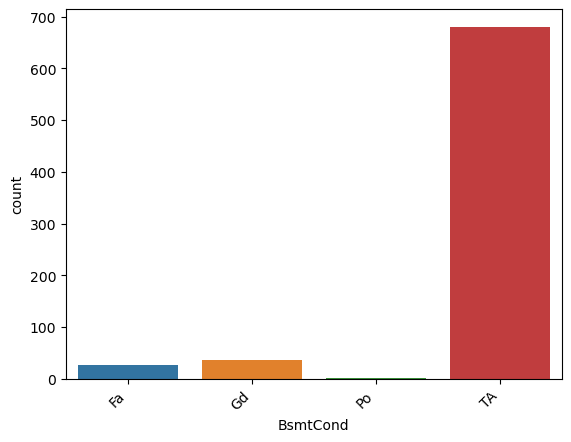

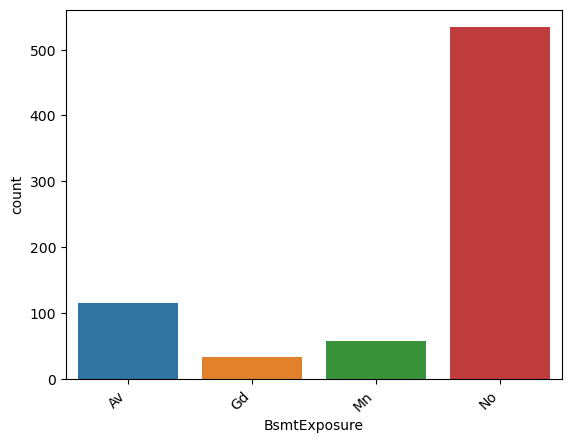

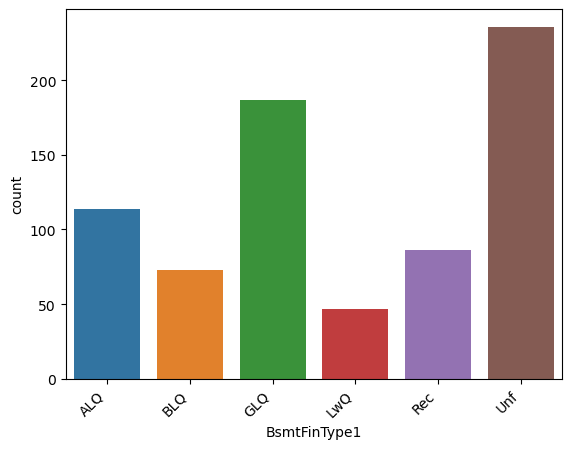

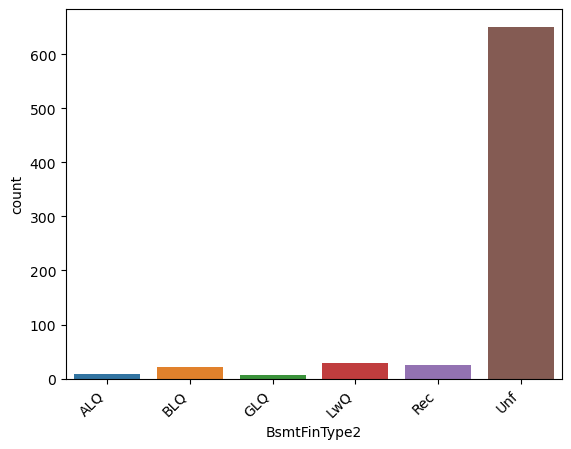

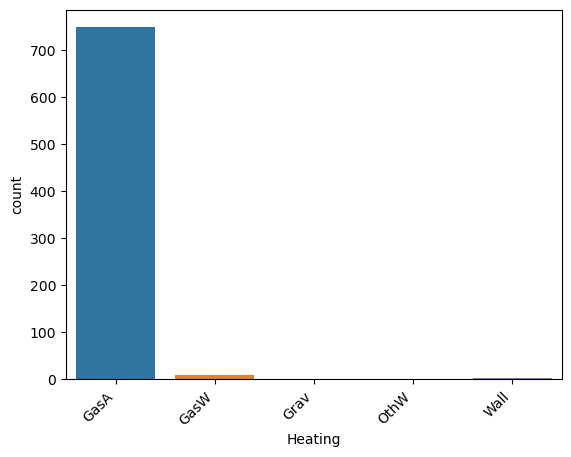

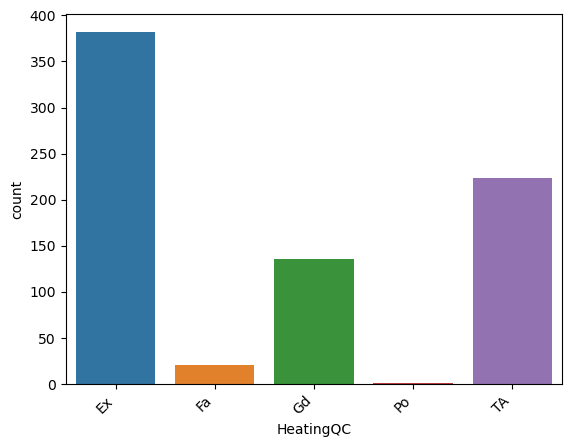

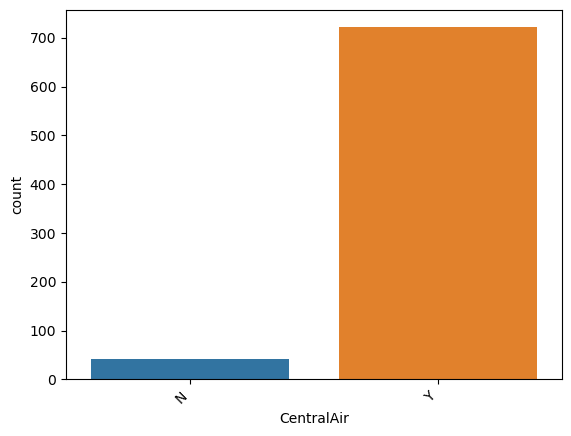

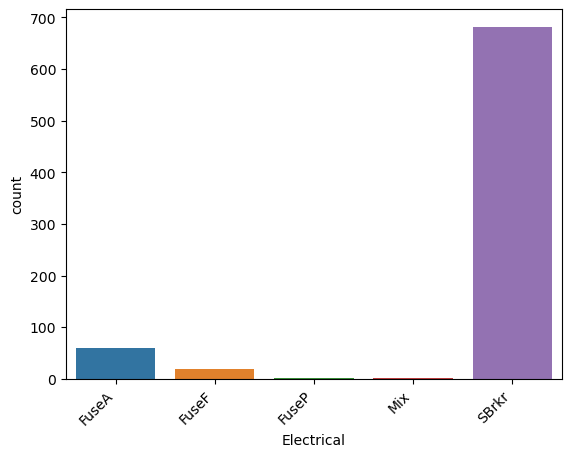

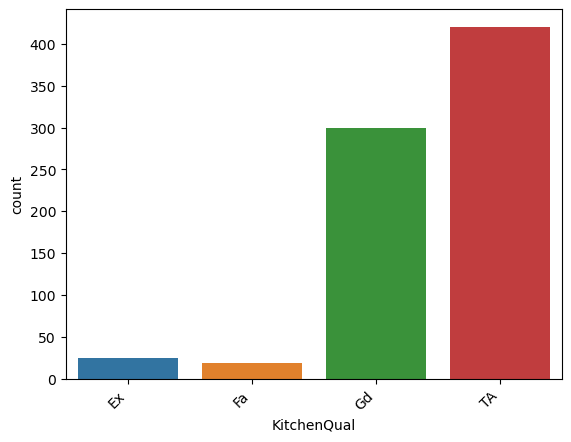

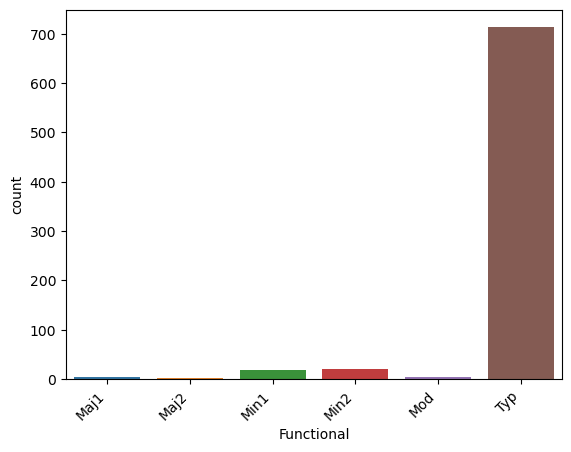

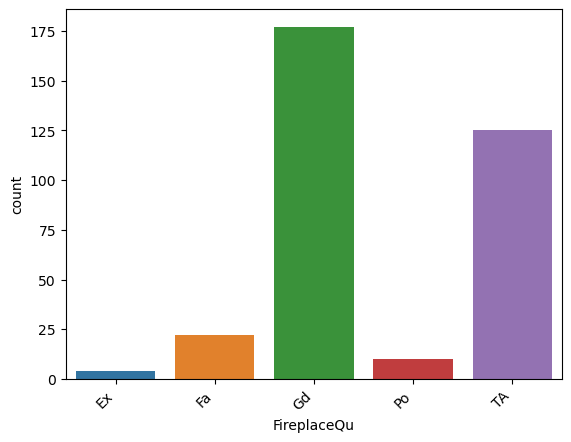

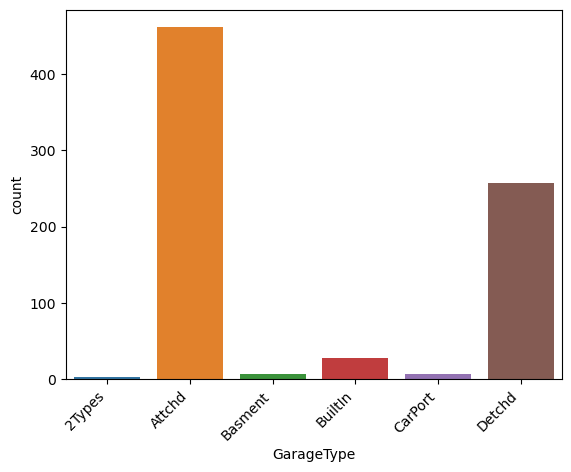

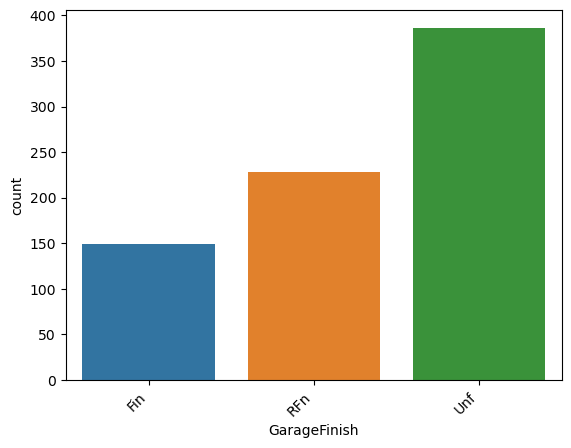

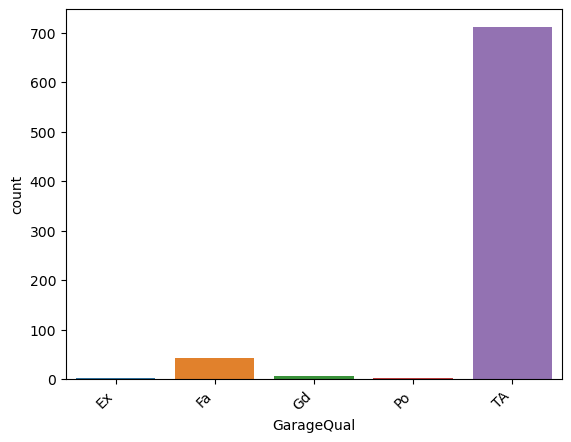

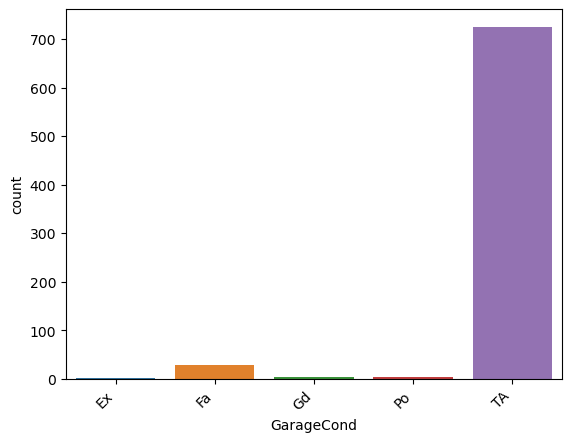

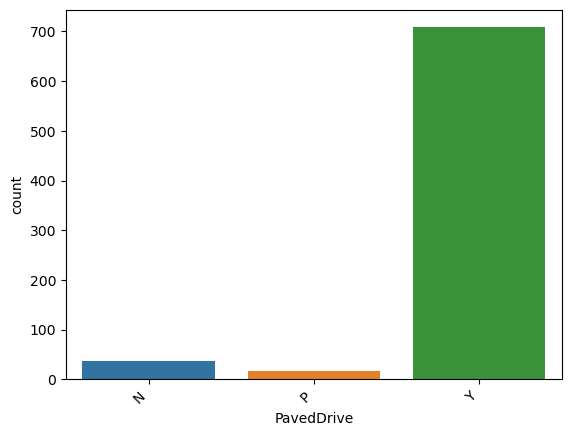

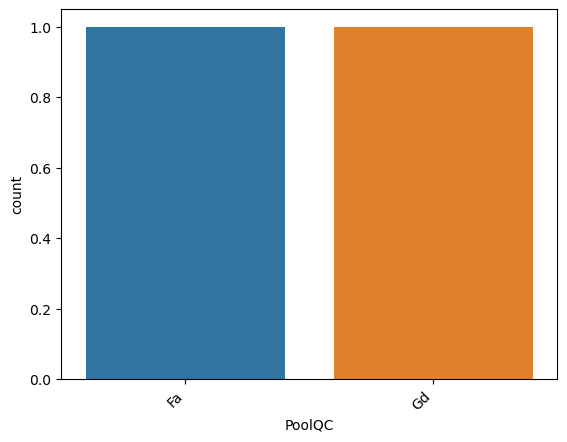

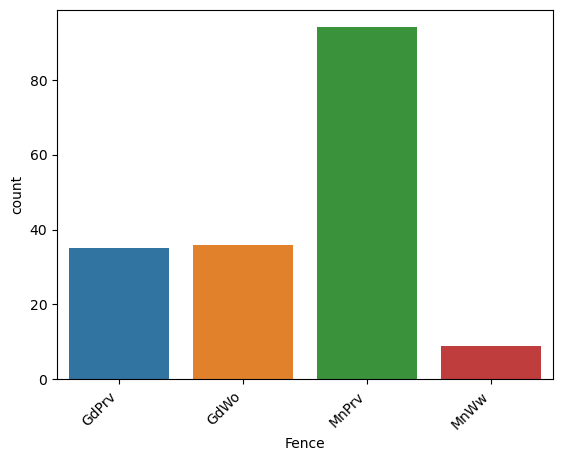

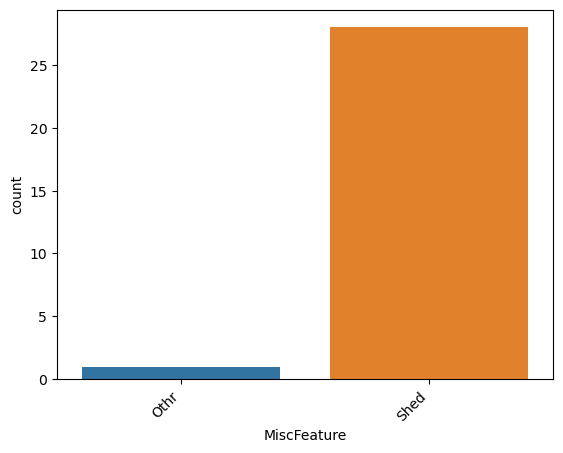

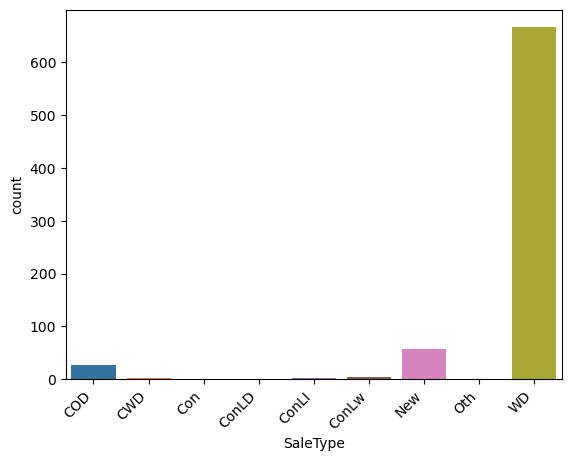

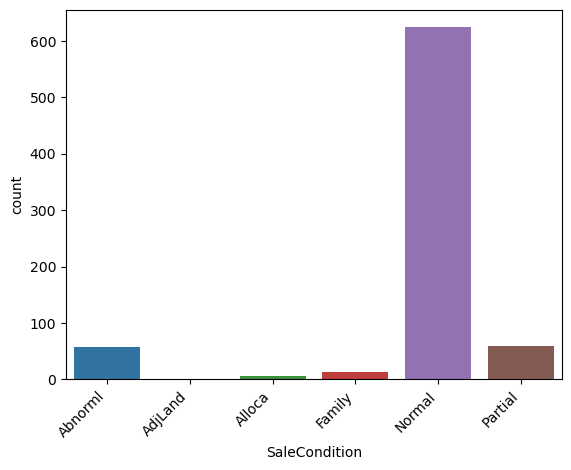

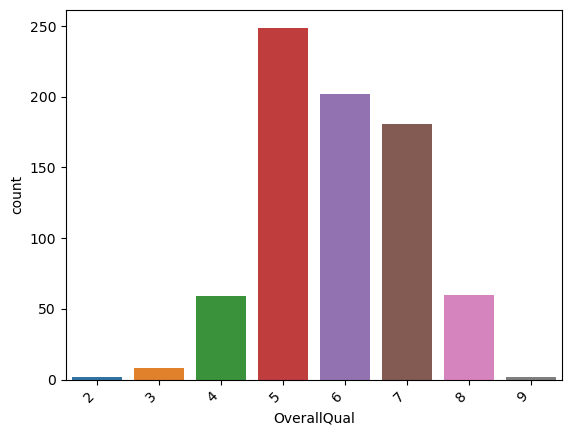

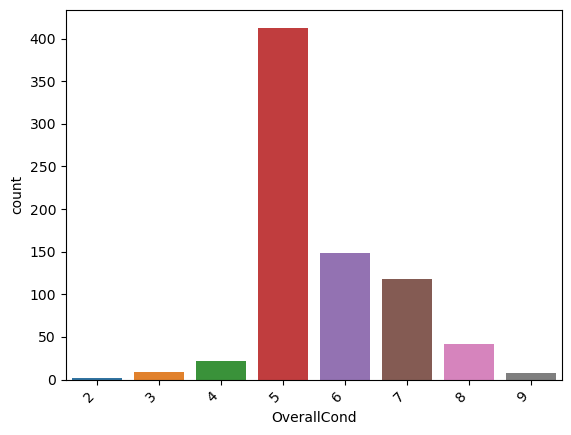

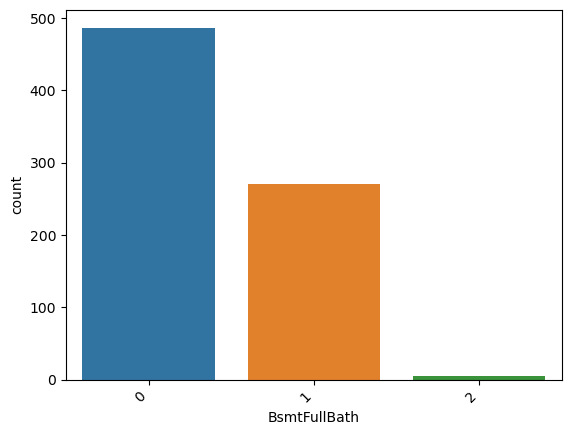

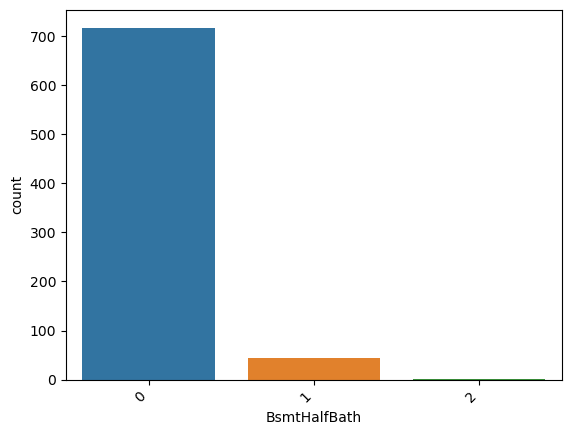

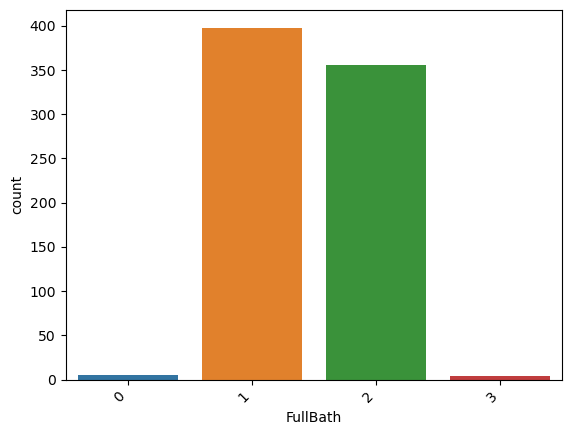

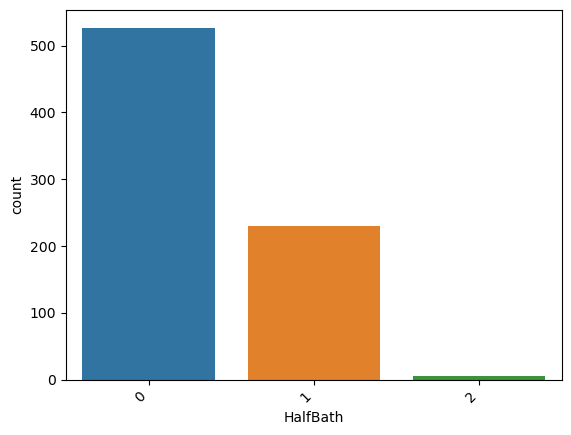

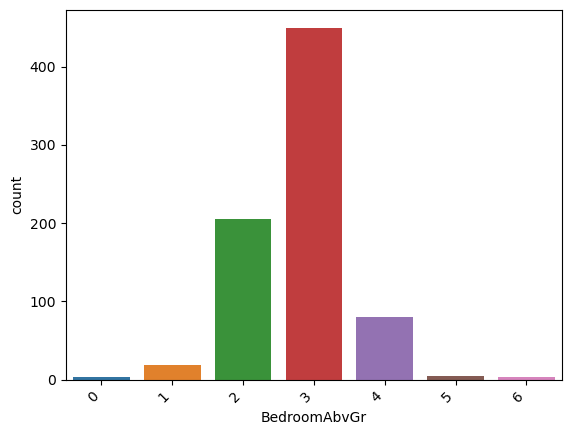

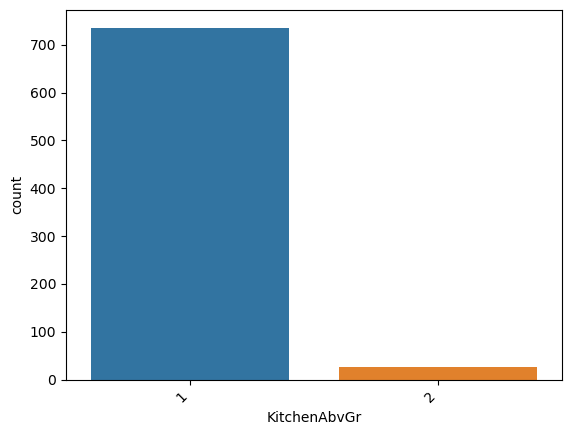

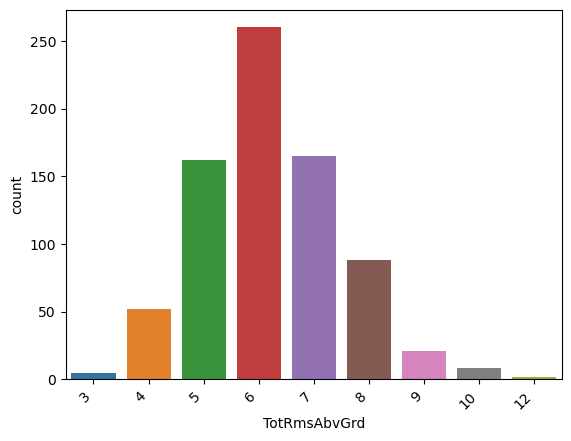

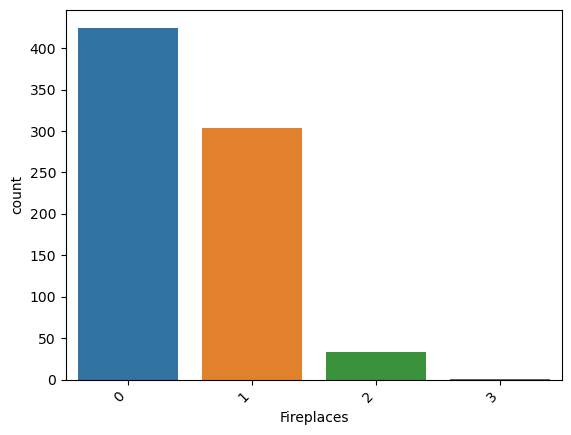

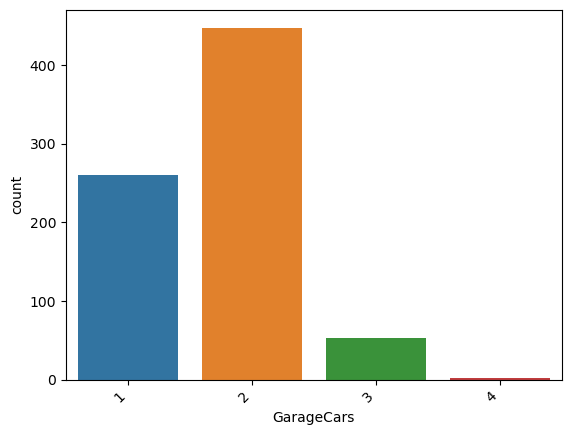

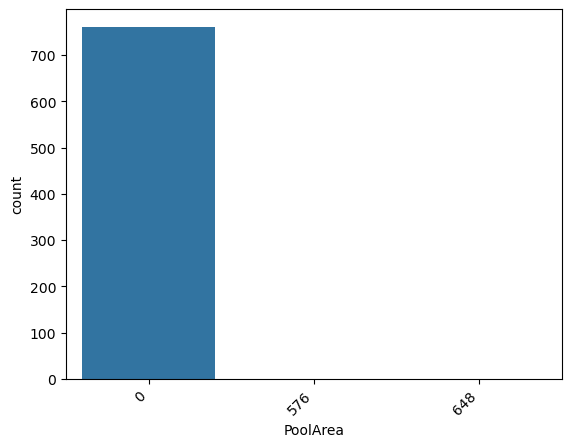

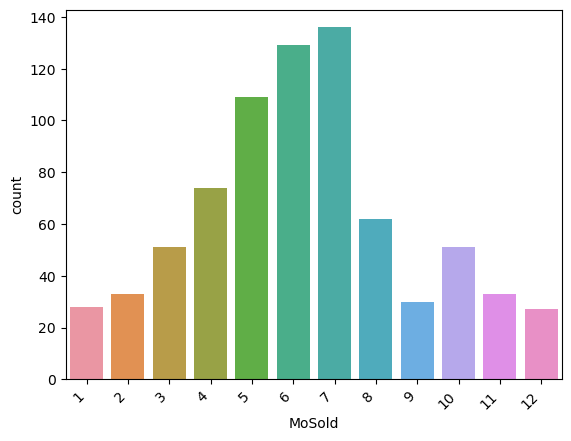

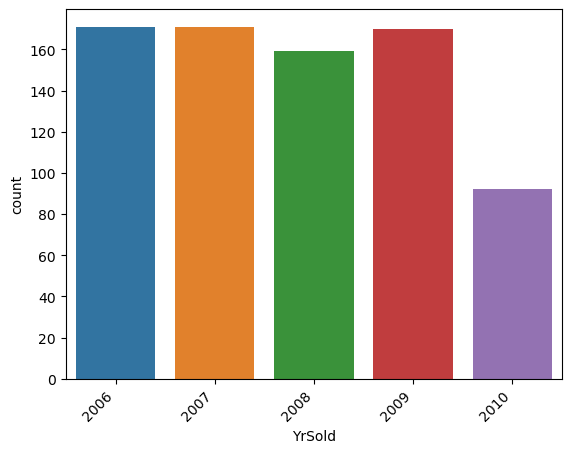

In [14]:
# Check imbalance data
for c in cat_cols:
    sorted_order =df[c].value_counts().index.sort_values()
    ax = sns.countplot(data=df, x=c,  order=sorted_order)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right') 
    plt.show()

In [15]:
# Check columns with only one value
columns = list(df.columns)
columns_values_count = {c: len(df[c].value_counts().index) for c in columns}
one_value_column = [c for c,v in columns_values_count.items() if v < 2]
if len(one_value_column) > 0:
    print(f'Columns that have only one values: {one_value_column}')
else:
    print('There is no column with only one value')

Columns that have only one values: ['Utilities']


In [16]:
# Remove column with one value
df = df.drop(columns = 'Utilities')

<Axes: >

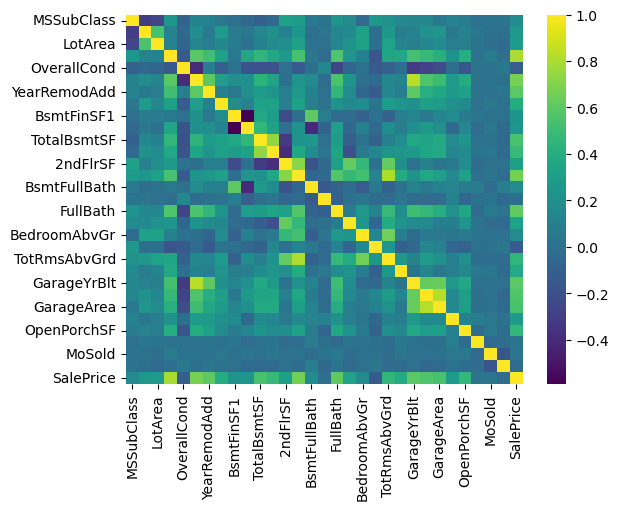

In [17]:
sns.heatmap(df.corr(numeric_only=True),cmap="viridis")

> Some highly correlated features. I will remove by p-value and VIF

# Data preparation

## Creating Derived Variables

In [18]:
# Creating derived column for total number of bathrooms column
# Mathematical transforms
df["LivLotRatio"] = df["GrLivArea"] / df["LotArea"]
df["Total_Home_Quality"] = df["OverallQual"] + df["OverallQual"]
df['TotalArea']=df['LotFrontage']+df['LotArea']
df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
df["Age"] = pd.to_numeric(df["YrSold"]) - pd.to_numeric(df["YearBuilt"])

# Group transforms
df["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")

In [19]:
#Lets drop these extra columns :
extraCols = ['GrLivArea','LotArea','OverallQual', 'OverallQual','LotFrontage',  'FullBath',
             'HalfBath','BsmtFullBath','BsmtHalfBath','YrSold','YearBuilt']
             
df.drop(extraCols,axis=1,inplace=True)


In [20]:
## Creating Dummy Varibles
df_train = pd.get_dummies(df,drop_first=True)
df_train.head()

,MSSubClass,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,BedroomAbvGr,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,5,2003,196.0,706,150,856,856,854,3,...,0,0,0,0,1,0,0,0,1,0
1,20,8,1976,0.0,978,284,1262,1262,0,3,...,0,0,0,0,1,0,0,0,1,0
2,60,5,2002,162.0,486,434,920,920,866,3,...,0,0,0,0,1,0,0,0,1,0
3,70,5,1970,0.0,216,540,756,961,756,3,...,0,0,0,0,1,0,0,0,0,0
4,60,5,2000,350.0,655,490,1145,1145,1053,4,...,0,0,0,0,1,0,0,0,1,0


# Model Building and Evaluation

In [21]:
import sklearn
from sklearn.model_selection import train_test_split #for spliting the data in terms of train and test
from sklearn.preprocessing import MinMaxScaler #for performing minmax scaling on the continous variables of training data
from sklearn.feature_selection import RFE #for performing automated Feature Selection
from sklearn.linear_model import LinearRegression #to build linear model
from sklearn.linear_model import Ridge #for ridge regularization
from sklearn.linear_model import Lasso #for lasso regularization
from sklearn.model_selection import GridSearchCV #finding the optimal parameter values
from sklearn.metrics import r2_score #for calculating the r-square value
import statsmodels.api as sm #for add the constant value
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor #to calculate the VIF
from sklearn.metrics import mean_squared_error #for calculating the mean squared error

## Train test split

In [22]:
train,test = train_test_split(df_train, train_size = 0.7, random_state = 100)
print("The Size of data:", df_train.shape)
print ("The Size of Train data: ",train.shape)
print ("The Size of Test data: ",test.shape)

The Size of data: (763, 215)
The Size of Train data:  (534, 215)
The Size of Test data:  (229, 215)


## Feature scale
- I use min-max scaling for numerical features

In [23]:
cat_cols, num_cols, cat_but_car = grab_col_names(train)

Observations: 534
Variables: 215
cat_cols: 199
num_cols: 16
cat_but_car: 0
num_but_cat: 199


In [24]:
scaler = MinMaxScaler() # Instantiate an objectr
#Note-The above order of columns in num_cols should be same in df_test, otherwise we will get a wrong r-square value
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

## Feature selection

In [25]:
y_train = train.pop('SalePrice')
X_train = train
y_test = test.pop('SalePrice')
X_test = test

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534 entries, 142 to 1002
Columns: 214 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(16), int64(10), uint8(188)
memory usage: 210.7 KB


In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534 entries, 142 to 1002
Columns: 214 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(16), int64(10), uint8(188)
memory usage: 210.7 KB


## Automation feature selection (RFE features)

In [28]:
# Use RFE chose 15 features
lm=LinearRegression()
lm.fit(X_train,y_train)
rfe=RFE(lm,n_features_to_select=100) # running RFE
rfe=rfe.fit(X_train,y_train)

In [29]:
# see the list of variables 
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('MSSubClass', False, 111),
 ('OverallCond', False, 32),
 ('YearRemodAdd', True, 1),
 ('MasVnrArea', False, 41),
 ('BsmtFinSF1', False, 107),
 ('BsmtUnfSF', True, 1),
 ('TotalBsmtSF', True, 1),
 ('1stFlrSF', True, 1),
 ('2ndFlrSF', True, 1),
 ('BedroomAbvGr', False, 89),
 ('KitchenAbvGr', False, 43),
 ('TotRmsAbvGrd', False, 104),
 ('Fireplaces', False, 24),
 ('GarageYrBlt', False, 99),
 ('GarageCars', False, 26),
 ('GarageArea', True, 1),
 ('WoodDeckSF', False, 33),
 ('OpenPorchSF', False, 28),
 ('PoolArea', False, 109),
 ('MoSold', False, 106),
 ('LivLotRatio', False, 19),
 ('Total_Home_Quality', False, 50),
 ('TotalArea', True, 1),
 ('Total_Bathrooms', False, 45),
 ('Age', True, 1),
 ('MedNhbdArea', True, 1),
 ('MSZoning_FV', True, 1),
 ('MSZoning_RH', True, 1),
 ('MSZoning_RL', True, 1),
 ('MSZoning_RM', True, 1),
 ('Street_Pave', True, 1),
 ('Alley_Pave', True, 1),
 ('LotShape_IR2', False, 81),
 ('LotShape_IR3', True, 1),
 ('LotShape_Reg', False, 82),
 ('LandContour_HLS', False, 

In [30]:
# RFE selected variabbles
col_rfe=X_train.columns[rfe.support_]
col_rfe

Index(['YearRemodAdd', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GarageArea', 'TotalArea', 'Age', 'MedNhbdArea', 'MSZoning_FV',
       'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Pave',
       'Alley_Pave', 'LotShape_IR3', 'LandContour_Low', 'LotConfig_FR2',
       'LandSlope_Sev', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
       'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV',
       'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer',
       'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
       'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_PosA',
       'Condition1_PosN', 'Condition1_RRAe', 'BldgType_2fmCon',
       'BldgType_Duplex', 'HouseStyle_

## Model building
- Prepare function
- Approach 1: Build models with all features
    - Ridge regression (Mode1)
    - Lasso regression (Mode2)
- Approach 2: When chose features by RFE, I eliminate more features by p_value and VIF
    - Ridge regression (Model3)
    - Lasso regression (Model4)
> Each Ridge/Lasso regresion, I fine tuning and chose the best param for the final

### Prepare function

In [82]:
class RIDGE():
    def __init__(self, X_train, y_train,X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def fine_turn(self,):
        # create alpha
        alpha = [0.0001, 0.001, 0.01, 0.05, 0.1, 
                0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
                4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]
        params = {'alpha':alpha}
        ridge = Ridge()
        # cross validation
        folds = 5
        ridge_model_cv = GridSearchCV(estimator = ridge, 
                                param_grid = params, 
                                scoring= 'r2', 
                                cv = folds, 
                                return_train_score=True,
                                verbose = 1)            
        ridge_model_cv.fit(self.X_train, self.y_train)
        ridge_cv_results = pd.DataFrame(ridge_model_cv.cv_results_)
        ridge_cv_results = ridge_cv_results[ridge_cv_results['param_alpha']<=100]
        print('para raking:',ridge_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score']))
        self.alpha = ridge_cv_results['param_alpha'].loc[ridge_cv_results['mean_test_score'].idxmax()]
        return ridge_cv_results
    def plot(self,ridge_cv_results) -> None:
        # plotting
        plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_train_score'])
        plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_test_score'])
        plt.xlabel('alpha')
        plt.ylabel('R2 Score')
        plt.title("R2 Score and Alpha")
        plt.legend(['train score', 'test score'], loc='upper right')
        plt.xticks(np.arange(0,100,5))
        plt.show()
    def print_the_best(self,) -> None:
        print('The optimum alpha is',self.alpha)
        ridge_final = Ridge(alpha=self.alpha)
        ridge_final.fit(self.X_train,self.y_train)
        y_test_pred = ridge_final.predict(self.X_test)
        print('The R2 Score of the model on the test dataset for optimum alpha is',r2_score(self.y_test, y_test_pred))
        print('The MSE of the model on the test dataset for optimum alpha is', mean_squared_error(self.y_test, y_test_pred))
    def print_most_important_var(self,)->None:
        ridge_final = Ridge(alpha=self.alpha)
        ridge_final.fit(self.X_train,self.y_train)
        ridge_coeff = ridge_final.coef_
        ridge_coeff = pd.DataFrame(np.atleast_2d(ridge_coeff),columns=self.X_train.columns)
        ridge_coeff = ridge_coeff.T
        ridge_coeff.rename(columns={0: 'Important Alpha Co-Efficient'},inplace=True)
        ridge_coeff.sort_values(by=['Important Alpha Co-Efficient'], ascending=False,inplace=True)
        print('The most important predictor variables are as follows:')
        print(ridge_coeff.head(20))


In [83]:
class LASSO():
    def __init__(self, X_train, y_train,X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
    
    def fine_tune(self,):
        lasso = Lasso()

        # Considering following alphas
        params = {'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01]}

        # cross validation
        folds = 5
        lasso_model_cv = GridSearchCV(estimator = lasso,                         
                                param_grid = params, 
                                scoring= 'r2', 
                                cv = folds, 
                                return_train_score=True,
                                verbose = 1)            

        lasso_model_cv.fit(X_train, y_train) 
        # display the mean scores
        lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
        print('para raking:',lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score']))
        self.alpha = lasso_cv_results['param_alpha'].loc[lasso_cv_results['mean_test_score'].idxmax()]
        return lasso_cv_results
    def plot(self,lasso_cv_results) -> None :
        plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
        plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
        plt.xlabel('alpha')
        plt.ylabel('R2 Score')
        plt.title("R2 Score and Alpha")
        plt.legend(['train score', 'test score'], loc='upper right')
        plt.show()
    def print_the_best(self,)-> None :
        print('The optimum alpha is',self.alpha)
        lasso_final2 = Lasso(alpha=self.alpha,random_state=100)
        lasso_final2.fit(self.X_train,self.y_train)
        y_test_pred = lasso_final2.predict(self.X_test)
        print('The R2 Score of the model on the test dataset for optimum alpha is',r2_score(self.y_test, y_test_pred))
        print('The MSE of the model on the test dataset for optimum alpha is', mean_squared_error(self.y_test, y_test_pred))
    def print_most_important_var(self,)->None:
        lasso_final = Lasso(alpha=self.alpha)
        lasso_final.fit(self.X_train,self.y_train)
        lasso_coeff = lasso_final.coef_
        lasso_coeff = pd.DataFrame(np.atleast_2d(lasso_coeff),columns=self.X_train.columns)
        lasso_coeff = lasso_coeff.T
        lasso_coeff.rename(columns={0: 'Important Alpha Co-Efficient'},inplace=True)
        lasso_coeff.sort_values(by=['Important Alpha Co-Efficient'], ascending=False,inplace=True)
        print('The most important predictor variables are as follows:')
        print(lasso_coeff.head(20))

###  Approach 1: Build models with all features

#### Model 1: Ridge regression

In [84]:
model1 = RIDGE(X_train,y_train, X_test, y_test) #X_train, y_train,X_test, y_test
ridge_cv_results = model1.fine_turn()
model1.print_the_best()

Fitting 5 folds for each of 28 candidates, totalling 140 fits
para raking:    param_alpha  mean_train_score  mean_test_score  rank_test_score
14         2.0          0.945194         0.883435                1
15         3.0          0.941017         0.883330                2
16         4.0          0.937516         0.882686                3
17         5.0          0.934462         0.881829                4
13         1.0          0.950554         0.881472                5
12         0.9          0.951197         0.880923                6
18         6.0          0.931731         0.880871                7
11         0.8          0.951869         0.880227                8
19         7.0          0.929246         0.879863                9
10         0.7          0.952572         0.879331               10
20         8.0          0.926956         0.878833               11
9          0.6          0.953312         0.878158               12
21         9.0          0.924828         0.877797     

In [85]:
model1.print_most_important_var()

The most important predictor variables are as follows:
                       Important Alpha Co-Efficient
2ndFlrSF                                   0.136293
1stFlrSF                                   0.131856
TotalBsmtSF                                0.093411
Neighborhood_Crawfor                       0.078230
BsmtFinSF1                                 0.055891
TotalArea                                  0.054394
GarageArea                                 0.047950
Neighborhood_Veenker                       0.040872
MedNhbdArea                                0.040267
SaleCondition_Partial                      0.040142
Neighborhood_NridgHt                       0.038918
Condition1_Norm                            0.038569
MSZoning_RL                                0.038014
OpenPorchSF                                0.036035
MSZoning_FV                                0.034211
MasVnrArea                                 0.033593
Exterior1st_BrkFace                        0.032437
Neighborh

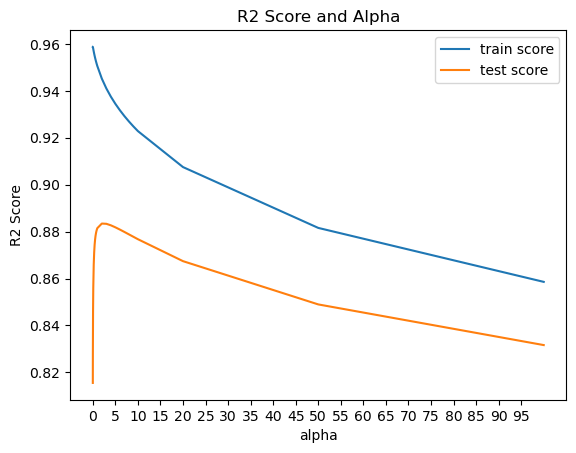

In [57]:
model1.plot(ridge_cv_results)

#### Model 2: Lasso regression

In [87]:
model2 = LASSO(X_train,y_train, X_test, y_test)
lasso_model_cv = model2.fine_tune()
model2.print_the_best()

Fitting 5 folds for each of 11 candidates, totalling 55 fits
para raking:    param_alpha  mean_train_score  mean_test_score  rank_test_score
3       0.0004          0.934120         0.891386                1
2       0.0003          0.938463         0.891110                2
4       0.0005          0.929718         0.889788                3
1       0.0002          0.943471         0.889783                4
0       0.0001          0.950251         0.885965                5
5        0.001          0.907896         0.874297                6
6        0.002          0.865490         0.835055                7
7        0.003          0.840238         0.813794                8
8        0.004          0.820336         0.795779                9
9        0.005          0.807729         0.784404               10
10        0.01          0.758698         0.740777               11
The optimum alpha is 0.0004
The R2 Score of the model on the test dataset for optimum alpha is 0.8754907805311707
The MSE 

In [89]:
model2.print_most_important_var()

The most important predictor variables are as follows:
                       Important Alpha Co-Efficient
1stFlrSF                                   0.188684
2ndFlrSF                                   0.185108
Neighborhood_Crawfor                       0.089685
TotalBsmtSF                                0.085700
BsmtFinSF1                                 0.054460
MedNhbdArea                                0.044662
TotalArea                                  0.040130
GarageArea                                 0.037743
Neighborhood_Somerst                       0.036702
Condition1_Norm                            0.033258
Neighborhood_NridgHt                       0.033065
Exterior1st_BrkFace                        0.030793
SaleCondition_Partial                      0.029245
OpenPorchSF                                0.028250
Exterior1st_CemntBd                        0.027337
GarageCars                                 0.024443
Functional_Typ                             0.022864
Total_Bat

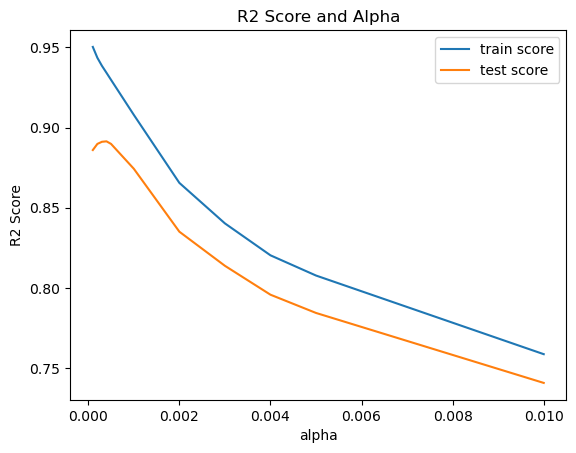

In [88]:
model2.plot(lasso_model_cv)

### Approach 2: When chose features by RFE, I elemenate more features by p_value and VIF

#### Chose features

In [37]:
X_train_rfe=X_train[col_rfe]
X_test_rfe = X_test[col_rfe]
X_train_rfe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534 entries, 142 to 1002
Data columns (total 100 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   YearRemodAdd           534 non-null    float64
 1   BsmtUnfSF              534 non-null    float64
 2   TotalBsmtSF            534 non-null    float64
 3   1stFlrSF               534 non-null    float64
 4   2ndFlrSF               534 non-null    float64
 5   GarageArea             534 non-null    float64
 6   TotalArea              534 non-null    float64
 7   Age                    534 non-null    float64
 8   MedNhbdArea            534 non-null    float64
 9   MSZoning_FV            534 non-null    uint8  
 10  MSZoning_RH            534 non-null    uint8  
 11  MSZoning_RL            534 non-null    uint8  
 12  MSZoning_RM            534 non-null    uint8  
 13  Street_Pave            534 non-null    uint8  
 14  Alley_Pave             534 non-null    uint8  
 15  Lo

In [38]:
# Add a constant
X_train_lm1 = sm.add_constant(X_train_rfe)
# Create a first fitted model
lr1 = sm.OLS(y_train, X_train_lm1).fit()
# Print a summary of the linear regression model obtained
print(lr1.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     58.69
Date:                Wed, 24 Jan 2024   Prob (F-statistic):          7.75e-198
Time:                        21:11:43   Log-Likelihood:                 812.91
No. Observations:                 534   AIC:                            -1444.
Df Residuals:                     443   BIC:                            -1054.
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.20

In [39]:
# Get the p-values from the summary
p_values = lr1.pvalues
# Set a threshold for significance (e.g., 0.05)
threshold = 0.05
# Identify features with high p-values
high_p_value_features = p_values[p_values > threshold].index
high_p_value_features = high_p_value_features.drop('const')
print("Features with high p-values:", high_p_value_features)


Features with high p-values: Index(['MedNhbdArea', 'Street_Pave', 'LotShape_IR3', 'LandContour_Low',
       'LandSlope_Sev', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_MeadowV',
       'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber',
       'Condition1_PosA', 'Condition1_PosN', 'BldgType_2fmCon',
       'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin',
       'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofStyle_Gable',
       'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard',
       'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'Exterior1st_BrkComm',
       'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_Stucco',
       'Exterior2nd_Brk Cmn',

Dropping cols with high p_values

In [40]:
# Dropping cols with high p_value
X_train_rfe2 = X_train_rfe.drop(high_p_value_features,axis=1)
X_test_rfe2 = X_test_rfe.drop(high_p_value_features,axis=1)

In [41]:
X_train_rfe2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534 entries, 142 to 1002
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   YearRemodAdd           534 non-null    float64
 1   BsmtUnfSF              534 non-null    float64
 2   TotalBsmtSF            534 non-null    float64
 3   1stFlrSF               534 non-null    float64
 4   2ndFlrSF               534 non-null    float64
 5   GarageArea             534 non-null    float64
 6   TotalArea              534 non-null    float64
 7   Age                    534 non-null    float64
 8   MSZoning_FV            534 non-null    uint8  
 9   MSZoning_RH            534 non-null    uint8  
 10  MSZoning_RL            534 non-null    uint8  
 11  MSZoning_RM            534 non-null    uint8  
 12  Alley_Pave             534 non-null    uint8  
 13  LotConfig_FR2          534 non-null    uint8  
 14  Neighborhood_BrkSide   534 non-null    uint8  
 15  Nei

In [42]:
# Function to calculate VIF for each feature
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Set a threshold for VIF
vif_threshold = 5  # You can adjust this threshold based on your needs

# Iterate until no feature has VIF above the threshold
while True:

    # Calculate VIF for each feature
    vif_data = calculate_vif(X_train_rfe2)

    # Identify features with the highest VIF
    max_vif_feature = vif_data.loc[vif_data['VIF'].idxmax()]['Feature']
    max_vif_value = vif_data.loc[vif_data['VIF'].idxmax()]['VIF']

    # Check if the highest VIF is above the threshold
    if max_vif_value > vif_threshold:
        # Drop the feature with the highest VIF
        X_train_rfe2 = X_train_rfe2.drop(max_vif_feature, axis=1)
        print(f"Dropped feature '{max_vif_feature}' with VIF {max_vif_value}")
    else:
        # Break the loop if no feature has VIF above the threshold
        break

print("Final DataFrame after VIF-based feature selection:")
X_train_rfe2.info()

Dropped feature 'MSZoning_RL' with VIF 85.89744643616068
Dropped feature 'MasVnrType_None' with VIF 36.91542118720215
Dropped feature 'TotalBsmtSF' with VIF 33.50765738765845


Dropped feature 'CentralAir_Y' with VIF 23.451506752094048
Dropped feature '1stFlrSF' with VIF 14.47877091918502
Dropped feature 'KitchenQual_TA' with VIF 13.52045492890891
Dropped feature 'Functional_Typ' with VIF 10.386652762199603
Dropped feature 'TotalArea' with VIF 9.902445666114716
Dropped feature 'YearRemodAdd' with VIF 5.927712774493206
Dropped feature 'Exterior1st_Wd Sdng' with VIF 5.648013418124334
Final DataFrame after VIF-based feature selection:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 534 entries, 142 to 1002
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   BsmtUnfSF              534 non-null    float64
 1   2ndFlrSF               534 non-null    float64
 2   GarageArea             534 non-null    float64
 3   Age                    534 non-null    float64
 4   MSZoning_FV            534 non-null    uint8  
 5   MSZoning_RH            534 non-null    uint8  
 6   MSZoning

#### Model 3: Ridge  regression

In [45]:
model3 = RIDGE(X_train[X_train_rfe2.columns],y_train, X_test[X_train_rfe2.columns], y_test) #X_train, y_train,X_test, y_test
ridge_cv_results = model3.fine_turn()
model3.print_the_best(ridge_cv_results)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
para raking:    param_alpha  mean_train_score  mean_test_score  rank_test_score
6          0.3          0.765379         0.737217                1
7          0.4          0.765151         0.737208                2
5          0.2          0.765561         0.737175                3
8          0.5          0.764887         0.737156                4
1          0.1          0.765686         0.737068                5
4          0.1          0.765686         0.737068                5
9          0.6          0.764594         0.737066                7
10         0.7          0.764277         0.736944                8
2         0.01          0.765734         0.736902                9
3        0.001          0.765734         0.736881               10
11         0.8          0.763938         0.736794               11
12         0.9          0.763581         0.736619               12
0            1          0.763208         0.736421     

#### Model4: Lasso regresion

In [46]:
model4 = LASSO(X_train[X_train_rfe2.columns],y_train, X_test[X_train_rfe2.columns], y_test)
lasso_model_cv = model4.fine_tune()
model4.print_the_best(lasso_model_cv)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
para raking:    param_alpha  mean_train_score  mean_test_score  rank_test_score
3       0.0004          0.934120         0.891386                1
2       0.0003          0.938463         0.891110                2
4       0.0005          0.929718         0.889788                3
1       0.0002          0.943471         0.889783                4
0       0.0001          0.950251         0.885965                5
5        0.001          0.907896         0.874297                6
6        0.002          0.865490         0.835055                7
7        0.003          0.840238         0.813794                8
8        0.004          0.820336         0.795779                9
9        0.005          0.807729         0.784404               10
10        0.01          0.758698         0.740777               11
The optimum alpha is 0.0004
The R2 Score of the model on the test dataset for optimum alpha is 0.6795130262262314
The MSE 

## Conclussion
1. The metrics result from approach 1 are higher than approach 2 
2.  With Ridge regression:
    - The optimum alpha is 2.0
    - The R2 Score of the model on the test dataset for optimum alpha is 0.8752062671978895
    - The MSE of the model on the test dataset for optimum alpha is 0.003967385658240671
3. With Lasso regression:
    - The optimum alpha is 0.0004
    - The R2 Score of the model on the test dataset for optimum alpha is 0.8754907805311707
    - The MSE of the model on the test dataset for optimum alpha is 0.003958340539606166

# Subjective Questions

1. What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?

What is the optimal value of alpha for ridge and lasso regression?
> Answer: The Optimal value of alpha for ridge is 2 and for lasso it is 0.0004.

What will be the changes in the model if you choose double the value of alpha for both ridge and lasso?

In [60]:
# Building Ridge Model by doubling the value of alpha to 4
ridge_double = Ridge(alpha=4,random_state=100)
ridge_double.fit(X_train,y_train)
ridge_double_coef = ridge_double.coef_
y_test_pred = ridge_double.predict(X_test)
print('The R2 Score of the model on the test dataset for doubled alpha is',r2_score(y_test, y_test_pred))
print('The MSE of the model on the test dataset for doubled alpha is', mean_squared_error(y_test, y_test_pred))
ridge_double_coeff = pd.DataFrame(np.atleast_2d(ridge_double_coef),columns=X_train.columns)
ridge_double_coeff = ridge_double_coeff.T
ridge_double_coeff.rename(columns={0: 'Ridge Doubled Alpha Co-Efficient'},inplace=True)
ridge_double_coeff.sort_values(by=['Ridge Doubled Alpha Co-Efficient'], ascending=False,inplace=True)
print('The most important predictor variables are as follows:')
ridge_double_coeff.head(20)

The R2 Score of the model on the test dataset for doubled alpha is 0.8700071691368036
The MSE of the model on the test dataset for doubled alpha is 0.0041326730217980025
The most important predictor variables are as follows:


,Ridge Doubled Alpha Co-Efficient
1stFlrSF,0.102410
2ndFlrSF,0.095409
TotalBsmtSF,0.077133
Neighborhood_Crawfor,0.070768
BsmtFinSF1,0.050777
TotalArea,0.047883
GarageArea,0.042884
MedNhbdArea,0.039198
Condition1_Norm,0.036869
Neighborhood_NridgHt,0.036484


In [61]:
# Building Lasso Model by doubling the value of alpha to 0.0008
lasso_double = Lasso(alpha=0.0008,random_state=100)
lasso_double.fit(X_train,y_train)
lasso_double_coef = lasso_double.coef_
y_test_pred = lasso_double.predict(X_test)
print('The R2 Score of the model on the test dataset for doubled alpha is',r2_score(y_test, y_test_pred))
print('The MSE of the model on the test dataset for doubled alpha is', mean_squared_error(y_test, y_test_pred))
lasso_double_coeff = pd.DataFrame(np.atleast_2d(lasso_double_coef),columns=X_train.columns)
lasso_double_coeff = lasso_double_coeff.T
lasso_double_coeff.rename(columns={0: 'Lasso Doubled Alpha Co-Efficient'},inplace=True)
lasso_double_coeff.sort_values(by=['Lasso Doubled Alpha Co-Efficient'], ascending=False,inplace=True)
print('The most important predictor variables are as follows:')
lasso_double_coeff.head(20)

The R2 Score of the model on the test dataset for doubled alpha is 0.8545382891753217
The MSE of the model on the test dataset for doubled alpha is 0.004624452625871135
The most important predictor variables are as follows:


,Lasso Doubled Alpha Co-Efficient
1stFlrSF,0.153345
2ndFlrSF,0.145544
Neighborhood_Crawfor,0.081604
TotalBsmtSF,0.072960
BsmtFinSF1,0.049909
Exterior1st_CemntBd,0.033792
GarageCars,0.029880
TotalArea,0.029820
GarageArea,0.029118
Condition1_Norm,0.028848


> Answer: The small alpha value leads to do not do any significant change in both regression model 1 and 2.